<a href="https://colab.research.google.com/github/debashisdotchatterjee/NFHS-paper-1/blob/main/NFHS_paper_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Basic Data Visualization Code

--- National (India) Level Key Indicators ---
India/States/UTs         India
edu_NFHS3_Total           58.3
edu_NFHS4_Total           68.8
pop_u15_NFHS3_Total       34.9
pop_u15_NFHS4_Total       28.6
stunting_NFHS3_Total      48.0
stunting_NFHS4_Total      38.4
wasting_NFHS3_Total       19.8
wasting_NFHS4_Total       21.0
underweight_NFHS3_Total   42.5
underweight_NFHS4_Total   35.7
u5mr_NFHS3_Total          74.0
u5mr_NFHS4_Total          50.0

--- State-Level Mean Values ---
edu_NFHS3_Total            64.325000
edu_NFHS4_Total            74.708333
pop_u15_NFHS3_Total        33.664286
pop_u15_NFHS4_Total        27.161111
stunting_NFHS3_Total       42.742857
stunting_NFHS4_Total       32.130556
wasting_NFHS3_Total        18.303571
wasting_NFHS4_Total        18.713889
underweight_NFHS3_Total    36.182143
underweight_NFHS4_Total    27.986111
u5mr_NFHS3_Total           61.571429
u5mr_NFHS4_Total           38.571429
dtype: float64


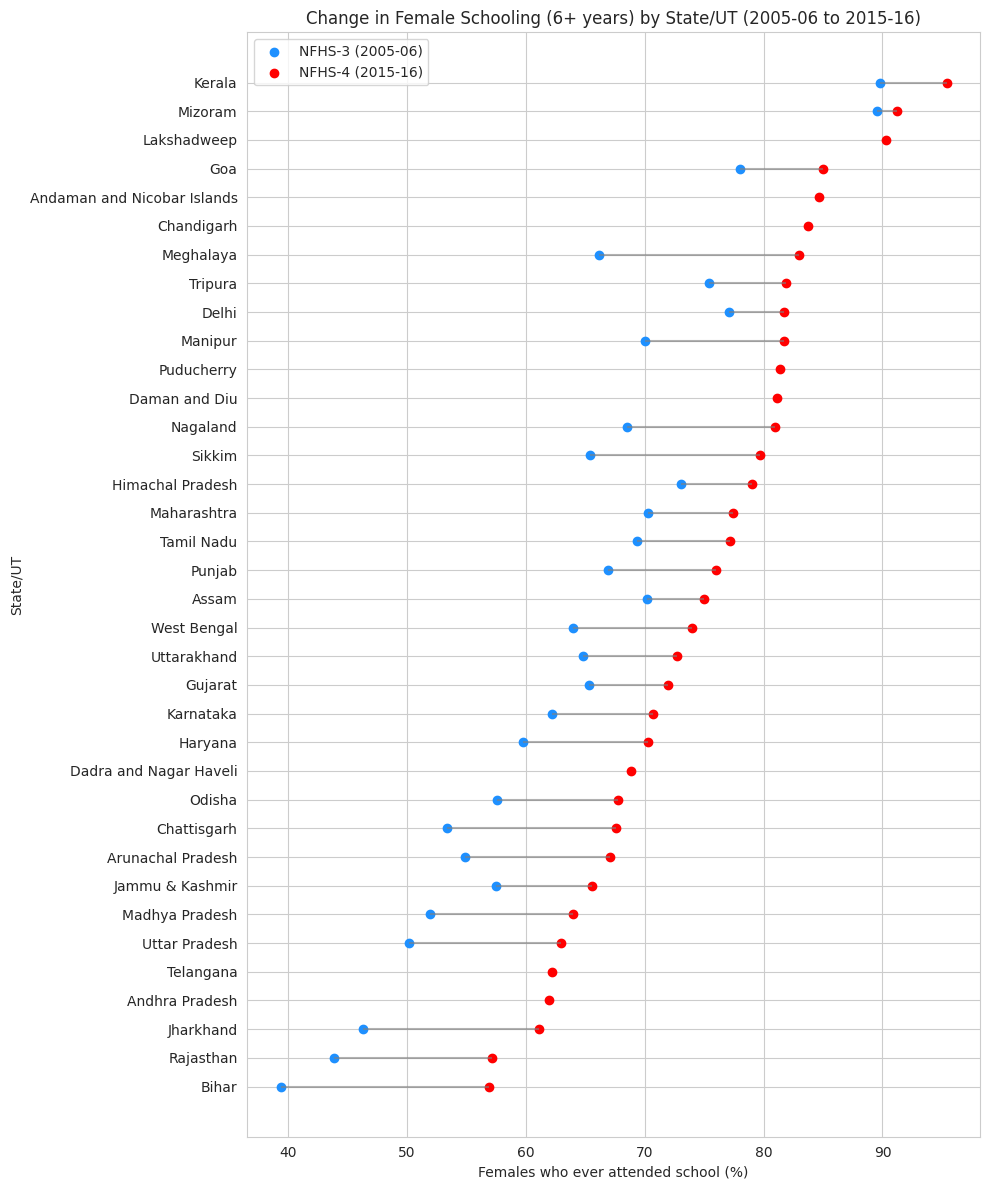

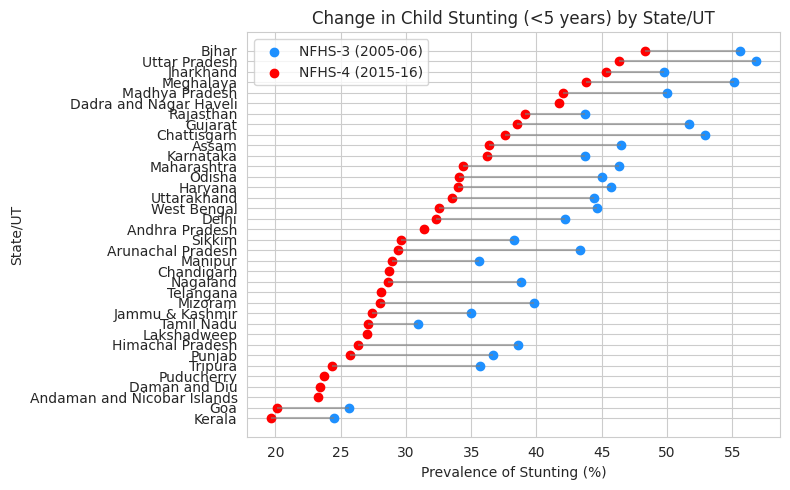

<Figure size 800x500 with 0 Axes>

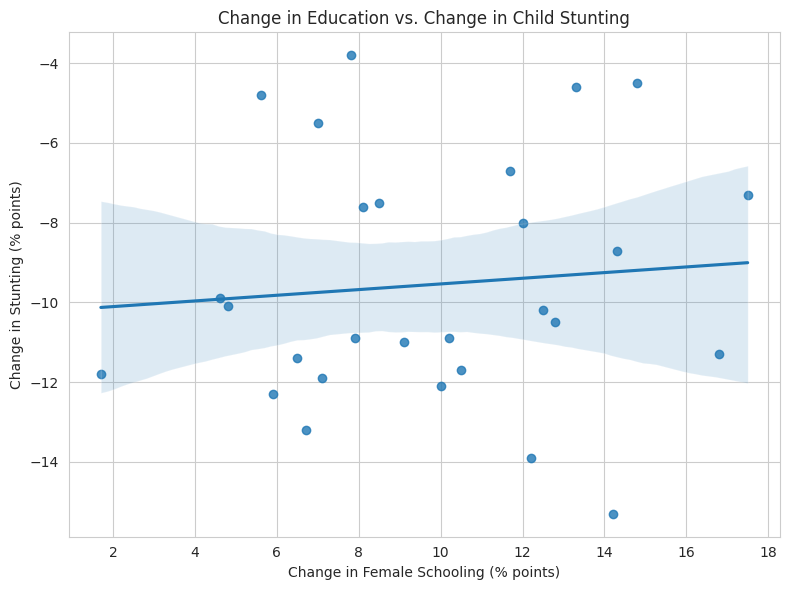

<Figure size 800x500 with 0 Axes>

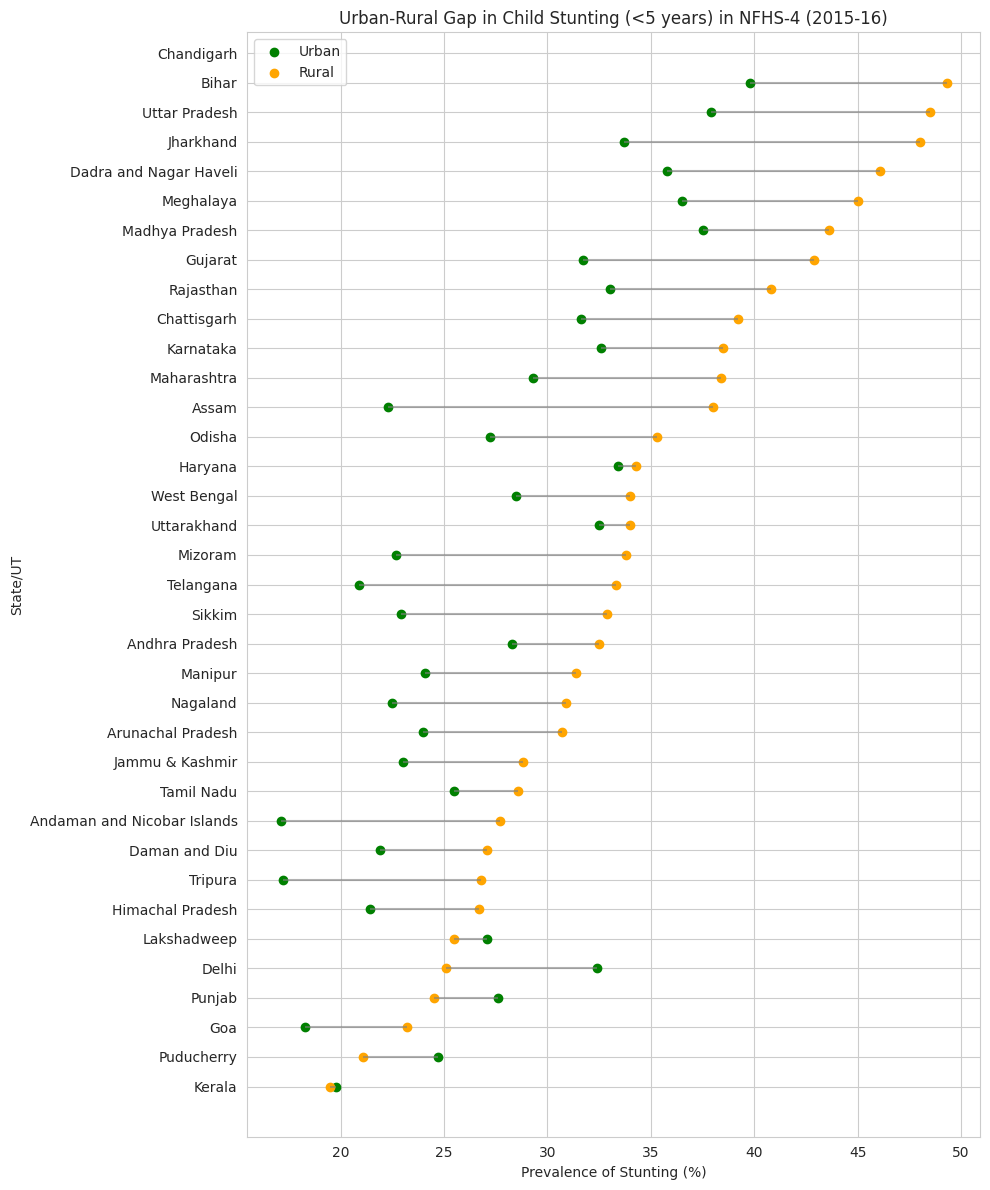

<Figure size 800x500 with 0 Axes>

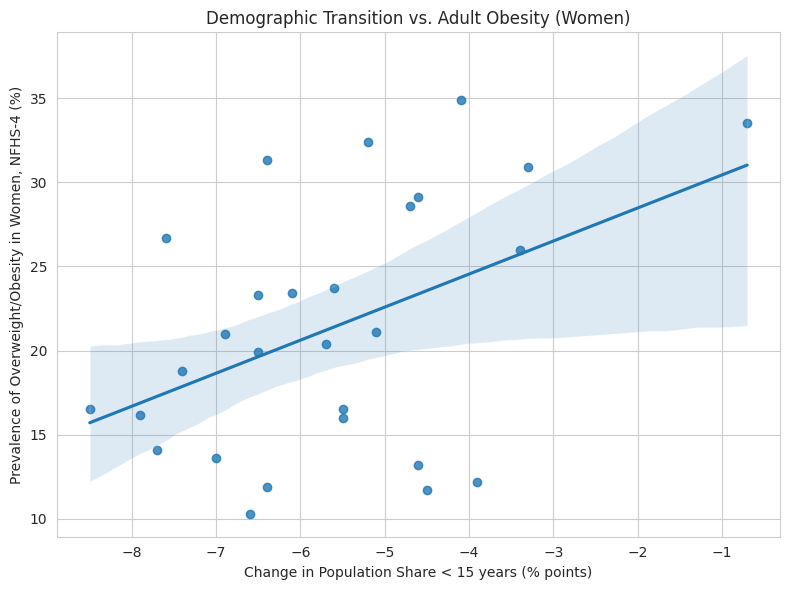

<Figure size 800x500 with 0 Axes>

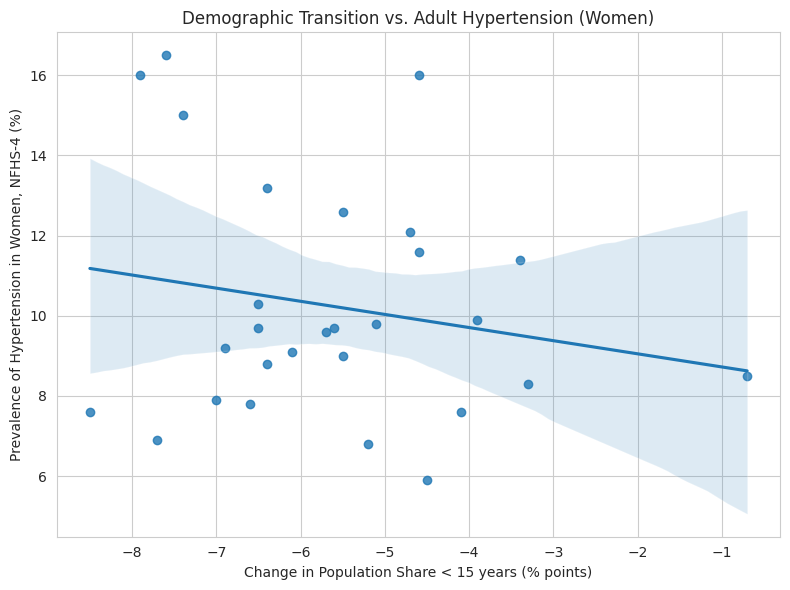


Successfully created plots_and_tables.zip


<Figure size 800x500 with 0 Axes>

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile

# Define short names for the long column names
indicator_mapping = {
    'edu': 'Population and Household Profile - Population (female) age 6 years and above who ever attended school (%)',
    'pop_u15': 'Population and Household Profile - Population below age 15 years (%)',
    'stunting': 'Child Feeding Practices and Nutritional Status of Children - Children under 5 years who are stunted (height-for-age) (%)',
    'wasting': 'Child Feeding Practices and Nutritional Status of Children - Children under 5 years who are wasted (weight-for-height) (%)',
    'underweight': 'Child Feeding Practices and Nutritional Status of Children - Children under 5 years who are underweight (weight-for-age) (%)',
    'u5mr': 'Infant and Child Mortality Rates (per 1000 live births) - Under-five mortality rate (U5MR)',
    'obesity_w': 'Nutritional Status of Adults (age 15-49 years) - Women who are overweight or obese (BMI >= 25.0 kg/m2) (%)',
    'bp_high_w1': 'Women - Slightly above normal (Systolic 140-159 mm of Hg and/or Diastolic 90-99 mm of Hg) (%)',
    'bp_high_w2': 'Women - Moderately high (Systolic 160-179 mm of Hg and/or Diastolic 100-109 mm of Hg) (%)',
    'bp_high_w3': 'Women - Very high (Systolic >= 180 mm of Hg and/or Diastolic >= 110 mm of Hg) (%)',
}

# Invert mapping for easier renaming
rename_dict = {v: k for k, v in indicator_mapping.items()}

# Load and select relevant columns
df = pd.read_csv('NFHS-4_NFHS3_Factsheet-All_India_Indicators_R1.csv')
cols_to_use = ['India/States/UTs', 'Survey', 'Area'] + list(indicator_mapping.values())
df_sub = df[cols_to_use]
df_sub = df_sub.rename(columns=rename_dict)

# Sum up hypertension columns for NFHS-4
for col in ['bp_high_w1', 'bp_high_w2', 'bp_high_w3']:
    df_sub[col] = pd.to_numeric(df_sub[col], errors='coerce')
df_sub['hypertension_w'] = df_sub[['bp_high_w1', 'bp_high_w2', 'bp_high_w3']].sum(axis=1)

# Drop the individual BP columns now they are summed
df_sub = df_sub.drop(columns=['bp_high_w1', 'bp_high_w2', 'bp_high_w3'])

# Pivot the table to get one row per state/UT
df_pivot = df_sub.pivot_table(
    index='India/States/UTs',
    columns=['Survey', 'Area'],
    values=[col for col in df_sub.columns if col not in ['India/States/UTs', 'Survey', 'Area']]
)

# Clean up column names (e.g., from ('stunting', 'NFHS-4', 'Total') to 'stunting_NFHS4_Total')
df_pivot.columns = ['_'.join(col).strip() for col in df_pivot.columns.values]

# As found before, NFHS-3 has no urban/rural, so those columns will be all NaN. Let's drop them.
cols_to_drop = [col for col in df_pivot.columns if 'NFHS-3' in col and ('Rural' in col or 'Urban' in col)]
df_pivot = df_pivot.drop(columns=cols_to_drop)

# Rename NFHS-3_Total to have a consistent naming scheme
df_pivot = df_pivot.rename(columns={col: col.replace('NFHS-3_Total', 'NFHS3_Total') for col in df_pivot.columns})
df_pivot = df_pivot.rename(columns={col: col.replace('NFHS-4', 'NFHS4') for col in df_pivot.columns})


# Calculate change scores (Delta) between NFHS-4 and NFHS-3 for 'Total' area
for indicator in ['edu', 'pop_u15', 'stunting', 'wasting', 'underweight', 'u5mr', 'obesity_w']:
    # Ensure columns are numeric, coercing errors
    nfhs3_col = f'{indicator}_NFHS3_Total'
    nfhs4_col = f'{indicator}_NFHS4_Total'
    df_pivot[nfhs3_col] = pd.to_numeric(df_pivot[nfhs3_col], errors='coerce')
    df_pivot[nfhs4_col] = pd.to_numeric(df_pivot[nfhs4_col], errors='coerce')
    df_pivot[f'Delta_{indicator}'] = df_pivot[nfhs4_col] - df_pivot[nfhs3_col]

# Separate India from states for analysis
df_india = df_pivot.loc[['India']]
df_states = df_pivot.drop('India')


# --- 1. Generate Tables ---
print("--- National (India) Level Key Indicators ---")
india_table = df_india[['edu_NFHS3_Total', 'edu_NFHS4_Total', 'pop_u15_NFHS3_Total', 'pop_u15_NFHS4_Total',
                        'stunting_NFHS3_Total', 'stunting_NFHS4_Total', 'wasting_NFHS3_Total', 'wasting_NFHS4_Total',
                        'underweight_NFHS3_Total', 'underweight_NFHS4_Total', 'u5mr_NFHS3_Total', 'u5mr_NFHS4_Total']]
print(india_table.transpose())
india_table.to_csv("table_1_national_indicators.csv")


print("\n--- State-Level Mean Values ---")
state_means = df_states[['edu_NFHS3_Total', 'edu_NFHS4_Total', 'pop_u15_NFHS3_Total', 'pop_u15_NFHS4_Total',
                         'stunting_NFHS3_Total', 'stunting_NFHS4_Total', 'wasting_NFHS3_Total', 'wasting_NFHS4_Total',
                         'underweight_NFHS3_Total', 'underweight_NFHS4_Total', 'u5mr_NFHS3_Total', 'u5mr_NFHS4_Total']].mean()
print(state_means)
state_means.to_csv("table_2_state_means.csv")


# --- 2. Generate Plots ---
# Set style for all plots
sns.set_style("whitegrid")
plt.figure(figsize=(10, 12))

# Plot 1: Female Schooling Change (Dumbbell Plot)
df_sorted = df_states.sort_values('edu_NFHS4_Total')
plt.hlines(y=df_sorted.index, xmin=df_sorted['edu_NFHS3_Total'], xmax=df_sorted['edu_NFHS4_Total'], color='grey', alpha=0.6)
plt.scatter(df_sorted['edu_NFHS3_Total'], df_sorted.index, color='dodgerblue', alpha=1, label='NFHS-3 (2005-06)')
plt.scatter(df_sorted['edu_NFHS4_Total'], df_sorted.index, color='red', alpha=1 , label='NFHS-4 (2015-16)')
plt.legend()
plt.title('Change in Female Schooling (6+ years) by State/UT (2005-06 to 2015-16)')
plt.xlabel('Females who ever attended school (%)')
plt.ylabel('State/UT')
plt.tight_layout()
plt.savefig("plot_1_female_schooling.png")
plt.show()
plt.clf()

# Plot 2: Stunting Change (Dumbbell Plot)
df_sorted = df_states.sort_values('stunting_NFHS4_Total')
plt.hlines(y=df_sorted.index, xmin=df_sorted['stunting_NFHS4_Total'], xmax=df_sorted['stunting_NFHS3_Total'], color='grey', alpha=0.6)
plt.scatter(df_sorted['stunting_NFHS3_Total'], df_sorted.index, color='dodgerblue', alpha=1, label='NFHS-3 (2005-06)')
plt.scatter(df_sorted['stunting_NFHS4_Total'], df_sorted.index, color='red', alpha=1 , label='NFHS-4 (2015-16)')
plt.legend()
plt.title('Change in Child Stunting (<5 years) by State/UT')
plt.xlabel('Prevalence of Stunting (%)')
plt.ylabel('State/UT')
plt.tight_layout()
plt.savefig("plot_2_stunting_change.png")
plt.show()
plt.clf()

# Plot 3: Scatter of Education Change vs. Stunting Change
plt.figure(figsize=(8, 6))
sns.regplot(data=df_states, x='Delta_edu', y='Delta_stunting', ci=95)
plt.title('Change in Education vs. Change in Child Stunting')
plt.xlabel('Change in Female Schooling (% points)')
plt.ylabel('Change in Stunting (% points)')
plt.grid(True)
plt.tight_layout()
plt.savefig("plot_3_edu_vs_stunting.png")
plt.show()
plt.clf()

# Plot 4: Urban-Rural Stunting Gap in NFHS-4
df_sorted = df_states.sort_values('stunting_NFHS4_Rural')
plt.figure(figsize=(10, 12))
plt.hlines(y=df_sorted.index, xmin=df_sorted['stunting_NFHS4_Urban'], xmax=df_sorted['stunting_NFHS4_Rural'], color='grey', alpha=0.6)
plt.scatter(df_sorted['stunting_NFHS4_Urban'], df_sorted.index, color='green', alpha=1, label='Urban')
plt.scatter(df_sorted['stunting_NFHS4_Rural'], df_sorted.index, color='orange', alpha=1 , label='Rural')
plt.legend()
plt.title('Urban-Rural Gap in Child Stunting (<5 years) in NFHS-4 (2015-16)')
plt.xlabel('Prevalence of Stunting (%)')
plt.ylabel('State/UT')
plt.tight_layout()
plt.savefig("plot_4_urban_rural_stunting_gap.png")
plt.show()
plt.clf()

# Plot 5: Scatter of Demographic Change vs. Obesity in NFHS-4
plt.figure(figsize=(8, 6))
sns.regplot(data=df_states, x='Delta_pop_u15', y='obesity_w_NFHS4_Total', ci=95)
plt.title('Demographic Transition vs. Adult Obesity (Women)')
plt.xlabel('Change in Population Share < 15 years (% points)')
plt.ylabel('Prevalence of Overweight/Obesity in Women, NFHS-4 (%)')
plt.grid(True)
plt.tight_layout()
plt.savefig("plot_5_demographics_vs_obesity.png")
plt.show()
plt.clf()

# Plot 6: Scatter of Demographic Change vs. Hypertension in NFHS-4
plt.figure(figsize=(8, 6))
sns.regplot(data=df_states, x='Delta_pop_u15', y='hypertension_w_NFHS4_Total', ci=95)
plt.title('Demographic Transition vs. Adult Hypertension (Women)')
plt.xlabel('Change in Population Share < 15 years (% points)')
plt.ylabel('Prevalence of Hypertension in Women, NFHS-4 (%)')
plt.grid(True)
plt.tight_layout()
plt.savefig("plot_6_demographics_vs_hypertension.png")
plt.show()
plt.clf()


# --- 3. Zip all the generated files ---
file_list = [
    "table_1_national_indicators.csv", "table_2_state_means.csv",
    "plot_1_female_schooling.png", "plot_2_stunting_change.png",
    "plot_3_edu_vs_stunting.png", "plot_4_urban_rural_stunting_gap.png",
    "plot_5_demographics_vs_obesity.png", "plot_6_demographics_vs_hypertension.png"
]
with zipfile.ZipFile('plots_and_tables.zip', 'w') as zipf:
    for file in file_list:
        if os.path.exists(file):
            zipf.write(file)
            os.remove(file) # Clean up individual files after zipping

print("\nSuccessfully created plots_and_tables.zip")


# Objectives Analyses

## Objective 1
- State-level change scores: ΔE<sub>s</sub>, ΔY<sub>s</sub>
- Baseline-adjusted OLS regressions for each outcome
- Elastic Net regression for Δ stunting

## Objective 2
- Rural/urban panel for NFHS-3 and NFHS-4
- Two-way fixed-effects model with:
  - State dummies
  - Area × survey interaction (DID-style specification)

## Objective 3
- PCA on 10 NCD indicators
- Construction of SETI (PC1)
- OLS of SETI on Δ population <15
- Correlation matrix between Δ population <15 and each NCD indicator

---

Data shape: (148, 192)
States/UTs: 37 unique
Surveys: ['NFHS-4' 'NFHS-3']
Areas: ['Total' 'Rural' 'Urban']

[WARN] pattern 'Under-five mortality rate (U5MR)' matched multiple columns; using first:
    Infant and Child Mortality Rates (per 1000 live births) - Under-five mortality rate (U5MR)
    Note of : Infant and Child Mortality Rates (per 1000 live births) - Under-five mortality rate (U5MR)
[WARN] pattern 'Nutritional Status of Adults (age 15-49 years) - Men who are overweight or obese' matched multiple columns; using first:
    Nutritional Status of Adults (age 15-49 years) - Men who are overweight or obese (BMI >= 25.0 kg/m2) (%)
    Note of : Nutritional Status of Adults (age 15-49 years) - Men who are overweight or obese (BMI >= 25.0 kg/m2) (%)
[WARN] pattern 'Women - Blood sugar level - high (>140 mg/dl)' matched multiple columns; using first:
    Women - Blood sugar level - high (>140 mg/dl) (%)
    Note of : Women - Blood sugar level - high (>140 mg/dl) (%)
[WARN] pattern 'Me

<Figure size 800x500 with 0 Axes>

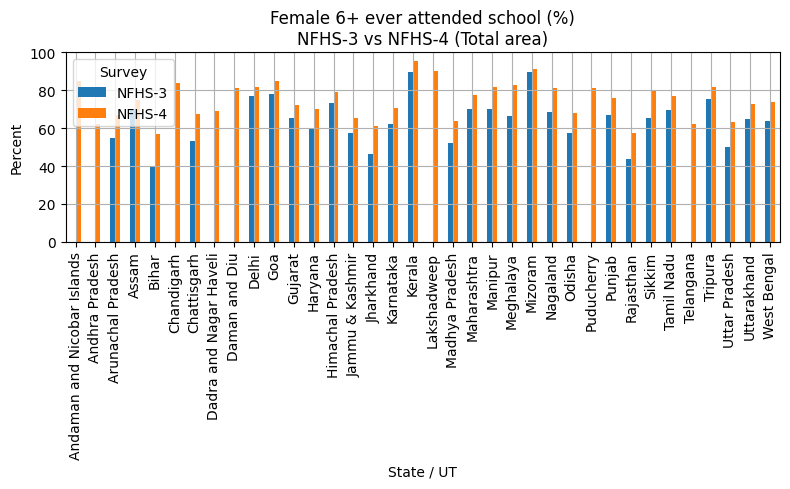

=== Change-score dataframe (first few rows) ===
               state  d_school  d_stunting  d_wasting  d_underweight  d_u5mr  \
0  Arunachal Pradesh      12.2       -13.9        2.0          -13.0   -55.0   
1              Assam       4.8       -10.1        3.3           -6.6   -28.0   
2              Bihar      17.5        -7.3       -6.3          -12.0   -26.0   
3        Chattisgarh      14.2       -15.3        3.6           -9.4   -26.0   
4              Delhi       4.6        -9.9        1.7            0.9     0.0   

   stunting_baseline  wasting_baseline  underweight_baseline  u5mr_baseline  
0               43.3              15.3                  32.5           88.0  
1               46.5              13.7                  36.4           84.0  
2               55.6              27.1                  55.9           84.0  
3               52.9              19.5                  47.1           90.0  
4               42.2              15.4                  26.1           47.0  

==

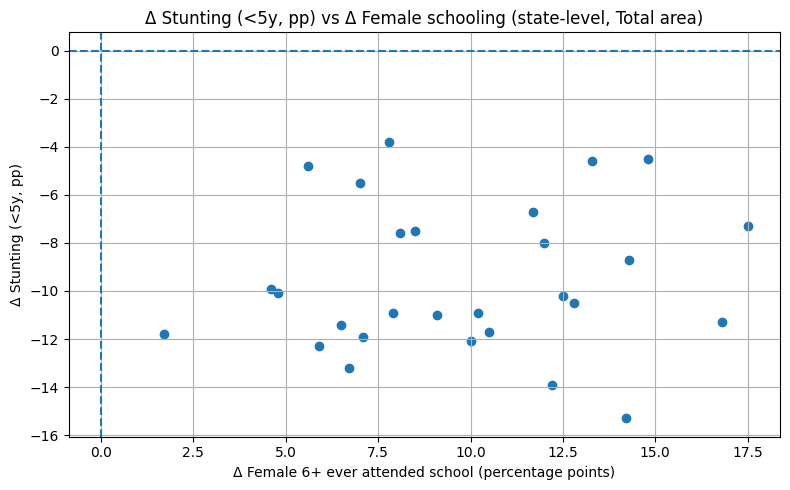

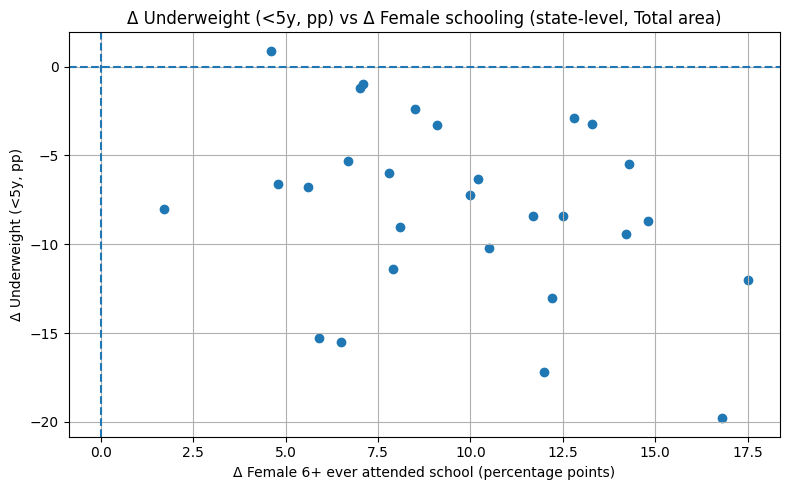

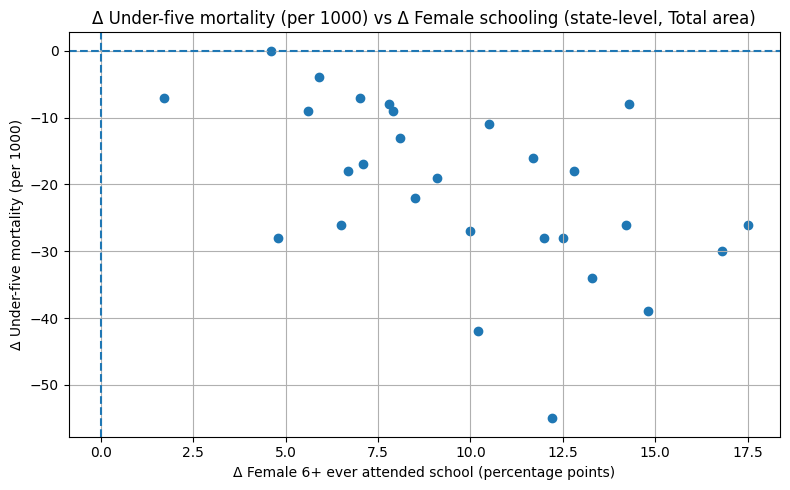

=== Urban–rural inequality model for stunting ===
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     8.262
Date:                Wed, 03 Dec 2025   Prob (F-statistic):           7.02e-09
Time:                        03:10:22   Log-Likelihood:                -164.42
No. Observations:                  70   AIC:                             400.8
Df Residuals:                      34   BIC:                             481.8
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

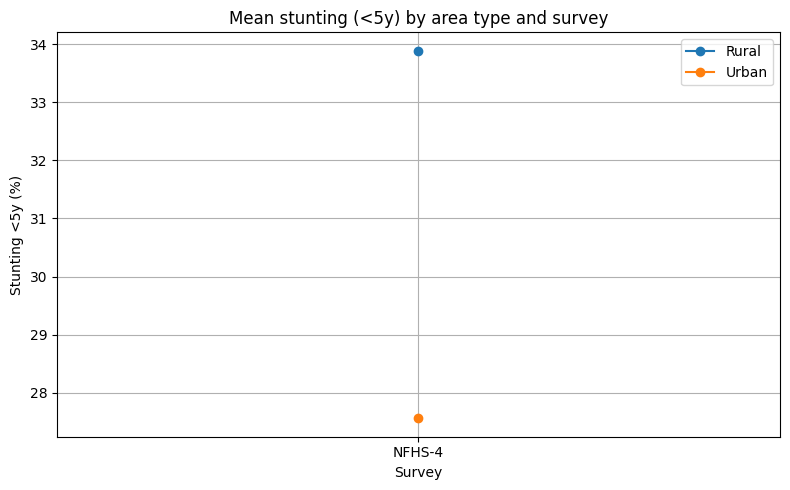

=== Demographic change (first few rows) ===
Survey                       NFHS-3  NFHS-4  delta_under15
India/States/UTs                                          
Andaman and Nicobar Islands     NaN    23.9            NaN
Andhra Pradesh                  NaN    23.7            NaN
Arunachal Pradesh              39.1    31.7           -7.4
Assam                          34.9    30.3           -4.6
Bihar                          43.8    39.3           -4.5

=== NCD panel with Δ under15 (first few rows) ===
  India/States/UTs  \
0            Assam   
1            Bihar   
2      Chattisgarh   
3          Gujarat   
4          Haryana   

   Nutritional Status of Adults (age 15-49 years) - Women who are overweight or obese (BMI >= 25.0 kg/m2) (%)  \
0                                               13.2                                                            
1                                               11.7                                                            
2                   

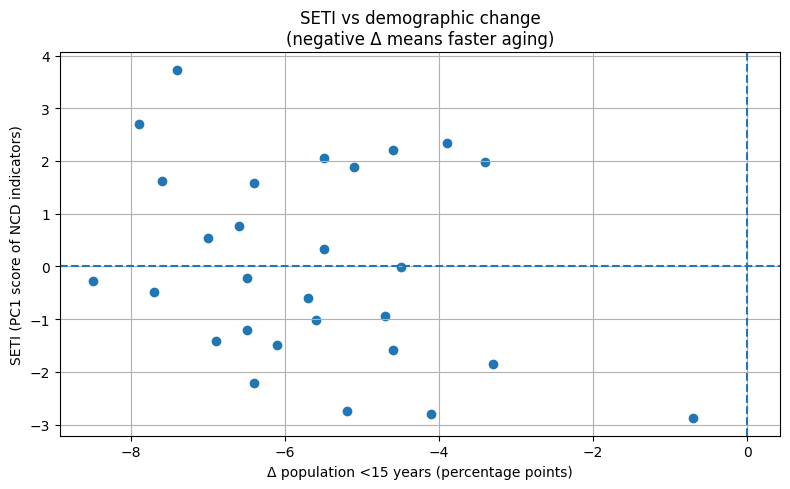


All outputs saved in 'nfhs_outputs/' and zipped as 'nfhs_outputs.zip'.


In [1]:
"""
NFHS-3 / NFHS-4 Epidemiological Transition Analysis
===================================================

Implements the methodology described in the LaTeX paper:

- Objective A: Education, child nutrition and under-five mortality.
- Objective B: Urban–rural inequality trends.
- Objective C: Demographic transition and NCD risk (SETI via PCA).

Outputs:
- Printed summary tables and model results.
- Matplotlib figures (shown inline).
- All figures and tables saved into 'nfhs_outputs/'.
- A zip archive 'nfhs_outputs.zip' with everything inside.

"""

# --------------------------------------------------
# 0. Imports and configuration
# --------------------------------------------------

import os
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

# Make plots a bit nicer
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

# Paths
DATA_PATH = "NFHS-4_NFHS3_Factsheet-All_India_Indicators_R1.csv"
OUTPUT_DIR = "nfhs_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --------------------------------------------------
# 1. Load data
# --------------------------------------------------

df = pd.read_csv(DATA_PATH)

state_col = "India/States/UTs"
survey_col = "Survey"
area_col = "Area"

print("Data shape:", df.shape)
print("States/UTs:", df[state_col].nunique(), "unique")
print("Surveys:", df[survey_col].unique())
print("Areas:", df[area_col].unique())
print()

# --------------------------------------------------
# 2. Helper: robust column finder
# --------------------------------------------------

def find_col(pattern):
    """
    Find the (unique) column containing a given substring.
    Raises if none found; warns if multiple.
    """
    matches = [c for c in df.columns if pattern in c]
    if not matches:
        raise ValueError(f"No column matches pattern: '{pattern}'")
    if len(matches) > 1:
        print(f"[WARN] pattern '{pattern}' matched multiple columns; using first:")
        for m in matches:
            print("   ", m)
    return matches[0]

# --------------------------------------------------
# 3. Identify key indicator columns
# --------------------------------------------------

# Education and demographic structure
col_female_school = find_col(
    "Population (female) age 6 years and above who ever attended school"
)
col_pop_under15 = find_col("Population below age 15 years")

# Child nutrition & mortality
col_stunted = find_col("Children under 5 years who are stunted")
col_wasted = find_col("Children under 5 years who are wasted (weight-for-height)")
col_underweight = find_col("under 5 years who are underweight")
col_u5mr = find_col("Under-five mortality rate (U5MR)")

# NCD-related indicators for NFHS-4
col_women_bmi_high = find_col(
    "Nutritional Status of Adults (age 15-49 years) - Women who are overweight or obese"
)
col_men_bmi_high = find_col(
    "Nutritional Status of Adults (age 15-49 years) - Men who are overweight or obese"
)
col_w_bg_high = find_col("Women - Blood sugar level - high (>140 mg/dl)")
col_m_bg_high = find_col("Men - Blood sugar level - high (>140 mg/dl)")
col_w_bp_very = find_col("Women - Very high (Systolic >=")
col_m_bp_very = find_col("Men - Very high (Systolic >=")
col_w_tobacco = find_col("Women who use any kind of tobacco")
col_m_tobacco = find_col("Men who use any kind of tobacco")
col_w_alcohol = find_col("Women who consume alcohol")
col_m_alcohol = find_col("Men who consume alcohol")

ncd_cols = [
    col_women_bmi_high,
    col_men_bmi_high,
    col_w_bg_high,
    col_m_bg_high,
    col_w_bp_very,
    col_m_bp_very,
    col_w_tobacco,
    col_m_tobacco,
    col_w_alcohol,
    col_m_alcohol,
]

print("\nSelected indicator columns:")
for c in [
    col_female_school,
    col_pop_under15,
    col_stunted,
    col_wasted,
    col_underweight,
    col_u5mr,
]:
    print("  ", c)
print("\nSelected NCD columns:")
for c in ncd_cols:
    print("  ", c)
print()

# Convenience subsets
df_states = df[df[state_col] != "India"].copy()
df_india = df[df[state_col] == "India"].copy()

df_states_total = df_states[df_states[area_col] == "Total"].copy()
df_states_ru = df_states[df_states[area_col].isin(["Rural", "Urban"])].copy()

# --------------------------------------------------
# 4. Descriptive statistics and plots (Tables 1 & 2, education plot)
# --------------------------------------------------

# 4.1 National-level table like Table 1
india_total = df_india[df_india[area_col] == "Total"].set_index(survey_col)

summary_india = india_total[
    [
        col_female_school,
        col_pop_under15,
        col_stunted,
        col_wasted,
        col_underweight,
        col_u5mr,
    ]
].copy()

summary_india = summary_india.rename(
    columns={
        col_female_school: "Female 6+ ever attended school (%)",
        col_pop_under15: "Population <15 years (%)",
        col_stunted: "Stunting <5y (%)",
        col_wasted: "Wasting <5y (%)",
        col_underweight: "Underweight <5y (%)",
        col_u5mr: "Under-five mortality (per 1000)",
    }
)

print("=== National-level summary (India, Total area) ===")
print(summary_india)
print()

summary_india.to_csv(os.path.join(OUTPUT_DIR, "summary_india.csv"))

# 4.2 State-level means like Table 2
state_means = (
    df_states_total.groupby(survey_col)[
        [col_female_school, col_pop_under15, col_stunted, col_wasted, col_underweight, col_u5mr]
    ]
    .mean()
    .rename(
        columns={
            col_female_school: "Female 6+ ever attended school (%)",
            col_pop_under15: "Population <15 years (%)",
            col_stunted: "Stunting <5y (%)",
            col_wasted: "Wasting <5y (%)",
            col_underweight: "Underweight <5y (%)",
            col_u5mr: "Under-five mortality (per 1000)",
        }
    )
)

print("=== State-level mean summary (Total area) ===")
print(state_means)
print()

state_means.to_csv(os.path.join(OUTPUT_DIR, "summary_state_means.csv"))

# 4.3 State-wise female schooling bar chart (NFHS-3 vs NFHS-4)

def pivot_total(col):
    return df_states_total.pivot(index=state_col, columns=survey_col, values=col)

school_wide = pivot_total(col_female_school)

plt.figure()
school_wide.plot(kind="bar")
plt.title("Female 6+ ever attended school (%)\nNFHS-3 vs NFHS-4 (Total area)")
plt.ylabel("Percent")
plt.xlabel("State / UT")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "female_schooling_bar_by_state.png"))
plt.show()

# --------------------------------------------------
# 5. Objective A: Education, child nutrition, and under-five mortality
# --------------------------------------------------

# Construct change scores (Total area, states only)
stunt_wide = pivot_total(col_stunted)
waste_wide = pivot_total(col_wasted)
under_wide = pivot_total(col_underweight)
u5mr_wide = pivot_total(col_u5mr)

change_df = pd.DataFrame(
    {
        "state": school_wide.index,
        "d_school": school_wide["NFHS-4"] - school_wide["NFHS-3"],
        "d_stunting": stunt_wide["NFHS-4"] - stunt_wide["NFHS-3"],
        "d_wasting": waste_wide["NFHS-4"] - waste_wide["NFHS-3"],
        "d_underweight": under_wide["NFHS-4"] - under_wide["NFHS-3"],
        "d_u5mr": u5mr_wide["NFHS-4"] - u5mr_wide["NFHS-3"],
        "stunting_baseline": stunt_wide["NFHS-3"],
        "wasting_baseline": waste_wide["NFHS-3"],
        "underweight_baseline": under_wide["NFHS-3"],
        "u5mr_baseline": u5mr_wide["NFHS-3"],
    }
)

# Drop states missing NFHS-3 values (newer states/UTs)
change_clean = change_df.dropna().reset_index(drop=True)

print("=== Change-score dataframe (first few rows) ===")
print(change_clean.head())
print()

change_clean.to_csv(os.path.join(OUTPUT_DIR, "change_scores_objectiveA.csv"), index=False)

# 5.1 Simple baseline-adjusted regressions: ΔY ~ ΔE + baseline(Y)

def run_baseline_regression(y_col, baseline_col, df_in):
    y = df_in[y_col]
    X = df_in[["d_school", baseline_col]]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    return model

outcomes = [
    ("d_stunting", "stunting_baseline", "Δ Stunting"),
    ("d_wasting", "wasting_baseline", "Δ Wasting"),
    ("d_underweight", "underweight_baseline", "Δ Underweight"),
    ("d_u5mr", "u5mr_baseline", "Δ U5MR"),
]

reg_results = []

for y_col, baseline_col, label in outcomes:
    model = run_baseline_regression(y_col, baseline_col, change_clean)
    params = model.params
    conf = model.conf_int()
    reg_results.append(
        {
            "Outcome": label,
            "beta_d_school": params["d_school"],
            "beta_d_school_low": conf.loc["d_school", 0],
            "beta_d_school_high": conf.loc["d_school", 1],
            "p_d_school": model.pvalues["d_school"],
            "R2": model.rsquared,
            "n_states": int(model.nobs),
        }
    )
    print(f"=== Regression for {label} ===")
    print(model.summary())
    print()

reg_table = pd.DataFrame(reg_results)
print("=== Summary of ΔE effect across outcomes ===")
print(reg_table)
print()

reg_table.to_csv(os.path.join(OUTPUT_DIR, "objectiveA_regression_summary.csv"), index=False)

# 5.2 Elastic Net multivariate view: example for ΔStunting

X_en = change_clean[
    [
        "d_school",
        "stunting_baseline",
        "wasting_baseline",
        "underweight_baseline",
        "u5mr_baseline",
    ]
].values
y_en = change_clean["d_stunting"].values

en = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.9],
    cv=5,
    random_state=123
)
en.fit(X_en, y_en)

en_coefs = pd.Series(
    en.coef_,
    index=[
        "d_school",
        "stunting_baseline",
        "wasting_baseline",
        "underweight_baseline",
        "u5mr_baseline",
    ]
)

print("=== Elastic Net for ΔStunting ===")
print("Alpha:", en.alpha_)
print("Best l1_ratio:", en.l1_ratio_)
print("Coefficients:")
print(en_coefs)
print()

en_coefs.to_csv(os.path.join(OUTPUT_DIR, "elasticnet_delta_stunting_coefs.csv"))

# 5.3 Scatter plots ΔEducation vs ΔStunting/ΔUnderweight/ΔU5MR

for y_col, label in [
    ("d_stunting", "Δ Stunting (<5y, pp)"),
    ("d_underweight", "Δ Underweight (<5y, pp)"),
    ("d_u5mr", "Δ Under-five mortality (per 1000)"),
]:
    plt.figure()
    plt.scatter(change_clean["d_school"], change_clean[y_col])
    plt.axhline(0, linestyle="--")
    plt.axvline(0, linestyle="--")
    plt.xlabel("Δ Female 6+ ever attended school (percentage points)")
    plt.ylabel(label)
    plt.title(f"{label} vs Δ Female schooling (state-level, Total area)")
    plt.tight_layout()
    fname = f"scatter_{y_col}_vs_d_school.png"
    plt.savefig(os.path.join(OUTPUT_DIR, fname))
    plt.show()

# --------------------------------------------------
# 6. Objective B: Urban–rural inequality
# --------------------------------------------------

# Prepare dataset for rural vs urban analysis (both surveys)
df_ru = df_states_ru[df_states_ru[survey_col].isin(["NFHS-3", "NFHS-4"])].copy()
df_ru["area_bin"] = (df_ru[area_col] == "Urban").astype(int)
df_ru["survey_num"] = (df_ru[survey_col] == "NFHS-4").astype(int)
df_ru = df_ru.rename(columns={state_col: "state"})

ineq_indicators = {
    "stunting": col_stunted,
    "underweight": col_underweight,
    "women_bmi_high": col_women_bmi_high,
    "men_bmi_high": col_men_bmi_high,
}

ineq_results = []

for short_name, col in ineq_indicators.items():
    df_i = df_ru[["state", "area_bin", "survey_num", col]].dropna().copy()
    df_i = df_i.rename(columns={col: "value"})

    # Fixed-effects regression with state dummies:
    # value ~ area_bin * survey_num + C(state)
    formula = "value ~ area_bin * survey_num + C(state)"
    model = smf.ols(formula, data=df_i).fit()

    alpha3 = model.params.get("area_bin:survey_num", np.nan)
    conf = model.conf_int()
    if "area_bin:survey_num" in conf.index:
        ci_low, ci_high = conf.loc["area_bin:survey_num"]
    else:
        ci_low = ci_high = np.nan

    ineq_results.append(
        {
            "indicator": short_name,
            "n_obs": int(model.nobs),
            "coef_area*survey": alpha3,
            "ci_low": ci_low,
            "ci_high": ci_high,
            "p_value": model.pvalues.get("area_bin:survey_num", np.nan),
            "R2": model.rsquared,
        }
    )

    print(f"=== Urban–rural inequality model for {short_name} ===")
    print(model.summary())
    print()

ineq_table = pd.DataFrame(ineq_results)
print("=== Summary: Change in urban–rural gap (interaction term) ===")
print(ineq_table)
print()

ineq_table.to_csv(os.path.join(OUTPUT_DIR, "objectiveB_inequality_summary.csv"), index=False)

# 6.1 Simple plot: mean rural vs urban stunting over time

def mean_by_area_survey(col):
    return (
        df_ru.groupby([survey_col, area_col])[col]
        .mean()
        .reset_index()
    )

mean_stunt = mean_by_area_survey(col_stunted)

plt.figure()
for area in ["Rural", "Urban"]:
    tmp = mean_stunt[mean_stunt[area_col] == area]
    plt.plot(tmp[survey_col], tmp[col_stunted], marker="o", label=area)
plt.xlabel("Survey")
plt.ylabel("Stunting <5y (%)")
plt.title("Mean stunting (<5y) by area type and survey")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "stunting_mean_rural_urban_by_survey.png"))
plt.show()

# --------------------------------------------------
# 7. Objective C: Demographic transition and NCD risk (SETI)
# --------------------------------------------------

# 7.1 Demographic change: Δ population <15 years (Total area)

demo_wide = pivot_total(col_pop_under15)
demo_wide["delta_under15"] = demo_wide["NFHS-4"] - demo_wide["NFHS-3"]

print("=== Demographic change (first few rows) ===")
print(demo_wide.head())
print()

demo_wide.to_csv(os.path.join(OUTPUT_DIR, "demographic_change_under15.csv"))

# 7.2 NCD indicators in NFHS-4 (Total area), merged with demographic change

states_total_nfhs4 = df_states_total[df_states_total[survey_col] == "NFHS-4"].copy()
ncd_panel = states_total_nfhs4[
    ["India/States/UTs"] + ncd_cols
].copy()

# Merge with demographic change (index = state names)
ncd_panel = ncd_panel.merge(
    demo_wide[["delta_under15"]],
    left_on="India/States/UTs",
    right_index=True,
    how="left",
)

# Drop states without baseline under-15 data
ncd_panel = ncd_panel.dropna(subset=["delta_under15"]).reset_index(drop=True)

print("=== NCD panel with Δ under15 (first few rows) ===")
print(ncd_panel.head())
print()

ncd_panel.to_csv(os.path.join(OUTPUT_DIR, "ncd_panel_objectiveC.csv"), index=False)

# 7.3 PCA on NCD indicators -> SETI

scaler = StandardScaler()
Z = scaler.fit_transform(ncd_panel[ncd_cols])

pca = PCA()
Z_pca = pca.fit_transform(Z)
expl_var = pca.explained_variance_ratio_

ncd_panel["SETI"] = Z_pca[:, 0]  # first principal component

print("=== PCA explained variance ratios (first few PCs) ===")
print(expl_var[:5])
print()

pca_loadings = pd.DataFrame(
    pca.components_.T,
    index=ncd_cols,
    columns=[f"PC{j+1}" for j in range(len(ncd_cols))]
)
print("=== PCA loadings (first two PCs) ===")
print(pca_loadings[["PC1", "PC2"]])
print()

pca_loadings.to_csv(os.path.join(OUTPUT_DIR, "pca_loadings_ncd.csv"))

# 7.4 Regression: SETI ~ Δ under15

X = sm.add_constant(ncd_panel["delta_under15"])
y = ncd_panel["SETI"]
model_seti = sm.OLS(y, X).fit()

print("=== Regression: SETI vs Δ population <15y ===")
print(model_seti.summary())
print()

seti_reg_summary = pd.DataFrame(
    {
        "coef": model_seti.params,
        "p_value": model_seti.pvalues,
        "ci_low": model_seti.conf_int()[0],
        "ci_high": model_seti.conf_int()[1],
    }
)
seti_reg_summary.to_csv(os.path.join(OUTPUT_DIR, "objectiveC_seti_regression.csv"))

# 7.5 Correlations: Δ under15 vs individual NCD indicators

corr_rows = []
for col in ncd_cols:
    r_pearson, p_pearson = stats.pearsonr(ncd_panel["delta_under15"], ncd_panel[col])
    r_spear, p_spear = stats.spearmanr(ncd_panel["delta_under15"], ncd_panel[col])
    corr_rows.append(
        {
            "indicator": col,
            "pearson_r": r_pearson,
            "pearson_p": p_pearson,
            "spearman_rho": r_spear,
            "spearman_p": p_spear,
        }
    )

corr_table = pd.DataFrame(corr_rows)
print("=== Correlations: Δ under15 vs NCD indicators ===")
print(corr_table)
print()

corr_table.to_csv(os.path.join(OUTPUT_DIR, "objectiveC_delta_under15_ncd_correlations.csv"), index=False)

# 7.6 Scatter plot: SETI vs Δ under15

plt.figure()
plt.scatter(ncd_panel["delta_under15"], ncd_panel["SETI"])
plt.axhline(0, linestyle="--")
plt.axvline(0, linestyle="--")
plt.xlabel("Δ population <15 years (percentage points)")
plt.ylabel("SETI (PC1 score of NCD indicators)")
plt.title("SETI vs demographic change\n(negative Δ means faster aging)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "scatter_SETI_vs_delta_under15.png"))
plt.show()

# --------------------------------------------------
# 8. Create zip archive with all outputs
# --------------------------------------------------

zip_path = "nfhs_outputs.zip"
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for root, dirs, files in os.walk(OUTPUT_DIR):
        for fname in files:
            full_path = os.path.join(root, fname)
            arcname = os.path.relpath(full_path, OUTPUT_DIR)
            z.write(full_path, arcname=arcname)

print(f"\nAll outputs saved in '{OUTPUT_DIR}/' and zipped as '{zip_path}'.")




## Advanced
- Joint multi-outcome test of the effect of Δ schooling across several child outcomes simultaneously (MANOVA), instead of only separate univariate regressions
- Cluster-robust standard errors for the rural–urban inequality models (to properly account for repeated observations within states)
- Extension of the PCA framework: regressing the “metabolic” axis (PC2) on Δ population <15, in addition to PC1/SETI

---

## New Code Cell as follows (assumes previous analysis already run: `df`, `df_ru`, `change_clean`, `ncd_panel`, `ncd_cols`, etc.)
This cell:
- Runs MANOVA for (Δ stunting, Δ underweight, Δ U5MR) vs predictors
- Refits the inequality models with cluster-robust SEs
- Builds a PC2-based metabolic index and regresses it on Δ population <15
- Prints all results
- Saves all new outputs in `nfhs_outputs_adv/`
- Zips them as `nfhs_outputs_adv.zip`

Data shape: (148, 192)
States/UTs: 37
Surveys: ['NFHS-4' 'NFHS-3']
Areas: ['Total' 'Rural' 'Urban']

[WARN] pattern 'Under-five mortality rate (U5MR)' matched multiple columns; using first:
    Infant and Child Mortality Rates (per 1000 live births) - Under-five mortality rate (U5MR)
    Note of : Infant and Child Mortality Rates (per 1000 live births) - Under-five mortality rate (U5MR)
[WARN] pattern 'Nutritional Status of Adults (age 15-49 years) - Men who are overweight or obese' matched multiple columns; using first:
    Nutritional Status of Adults (age 15-49 years) - Men who are overweight or obese (BMI >= 25.0 kg/m2) (%)
    Note of : Nutritional Status of Adults (age 15-49 years) - Men who are overweight or obese (BMI >= 25.0 kg/m2) (%)
[WARN] pattern 'Women - Blood sugar level - high (>140 mg/dl)' matched multiple columns; using first:
    Women - Blood sugar level - high (>140 mg/dl) (%)
    Note of : Women - Blood sugar level - high (>140 mg/dl) (%)
[WARN] pattern 'Men - Blo

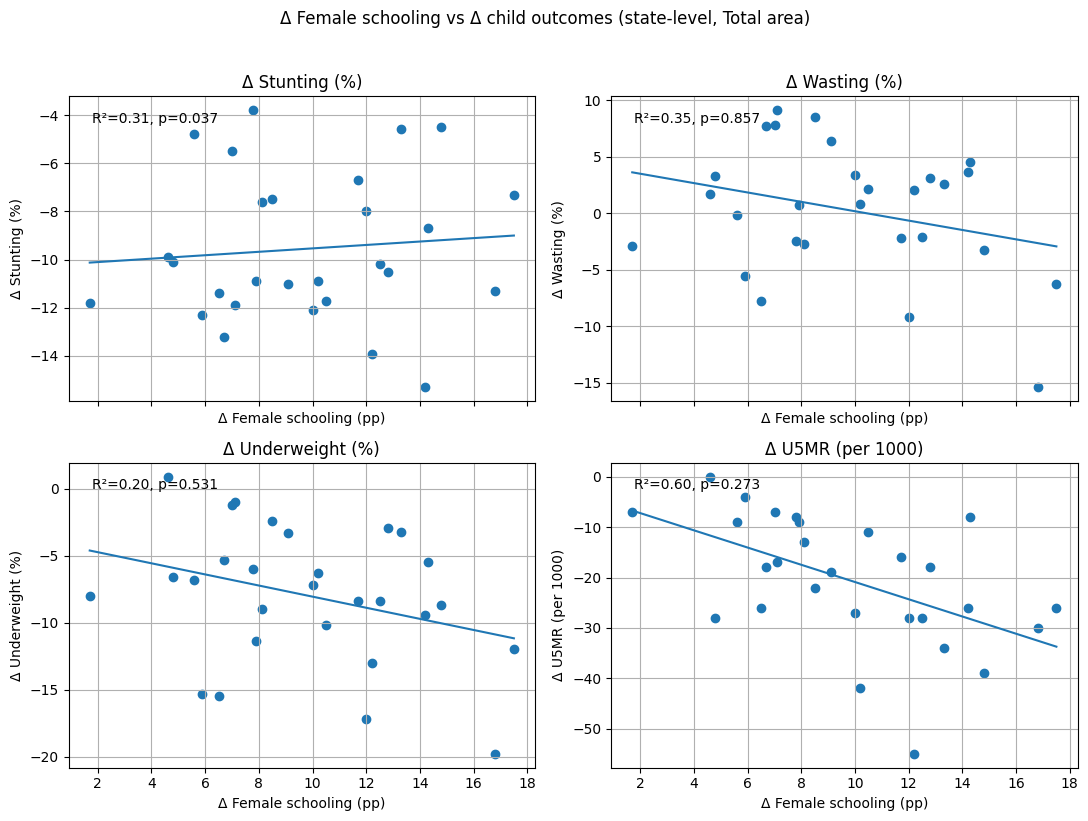

Saved multi-panel regression figure to: nfhs_outputs_advanced/objective1_multi_panel_regressions.png



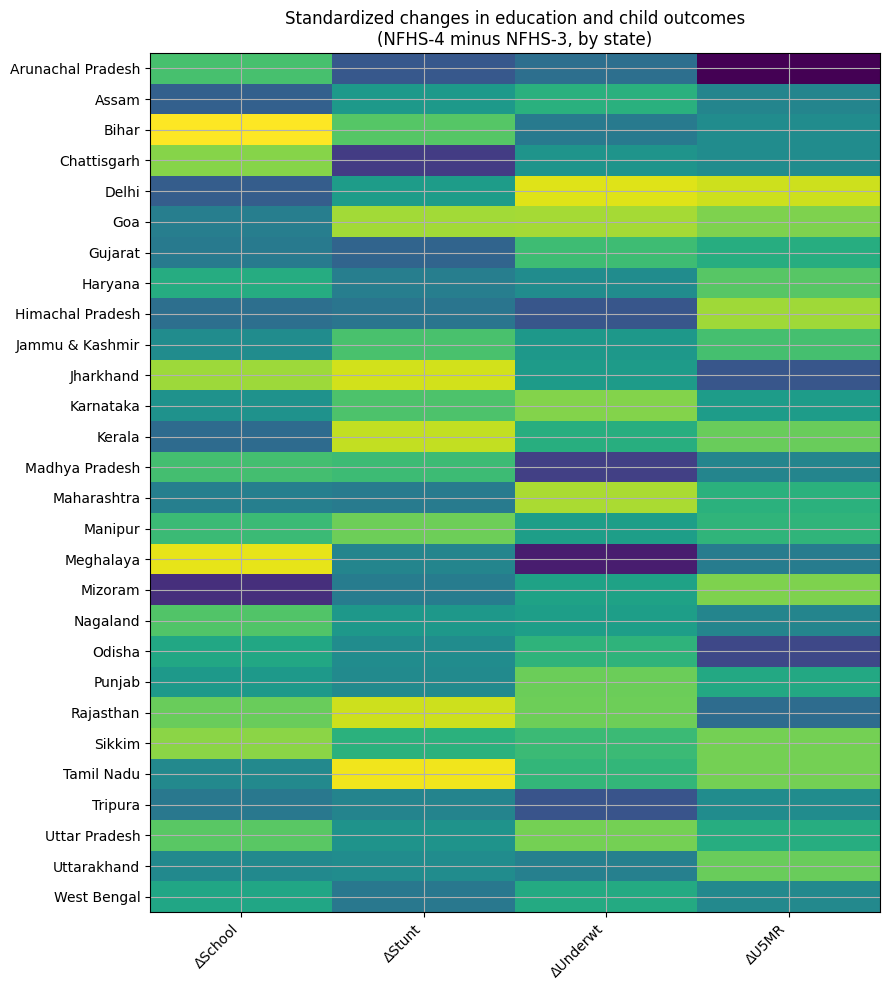

Saved heatmap to: nfhs_outputs_advanced/objective1_state_change_heatmap.png

=== Quartile summary by Δschool (mean changes) ===
                 d_stunting  d_wasting  d_underweight     d_u5mr
school_quartile                                                 
1                -10.500000  -0.542857      -8.085714 -13.142857
2                 -8.314286   3.900000      -4.900000 -13.571429
3                -10.500000  -0.742857     -10.100000 -29.571429
4                 -8.885714  -1.600000      -8.785714 -25.857143

Saved quartile summary to: nfhs_outputs_advanced/objective1_quartile_summary.csv

=== Cluster-robust FE model for stunting ===


/tmp/ipython-input-4036621171.py:355: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quart_summary = change_quart.groupby("school_quartile")[
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 37, but rank is 1
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     78.37
Date:                Wed, 03 Dec 2025   Prob (F-statistic):           2.40e-10
Time:                        03:53:43   Log-Likelihood:                -164.42
No. Observations:                  70   AIC:                             400.8
Df Residuals:                      34   BIC:                             481.8
Df Model:                          35                                         
Covariance Type:              cluster                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 37, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 37, but rank is 1
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     13.74
Date:                Wed, 03 Dec 2025   Prob (F-statistic):           0.000744
Time:                        03:53:43   Log-Likelihood:                -170.84
No. Observations:                  70   AIC:                             413.7
Df Residuals:                      34   BIC:                             494.6
Df Model:                          35                                         
Covariance Type:              cluster                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 37, but rank is 1
  warnings.warn('covariance of constraints does not have full '


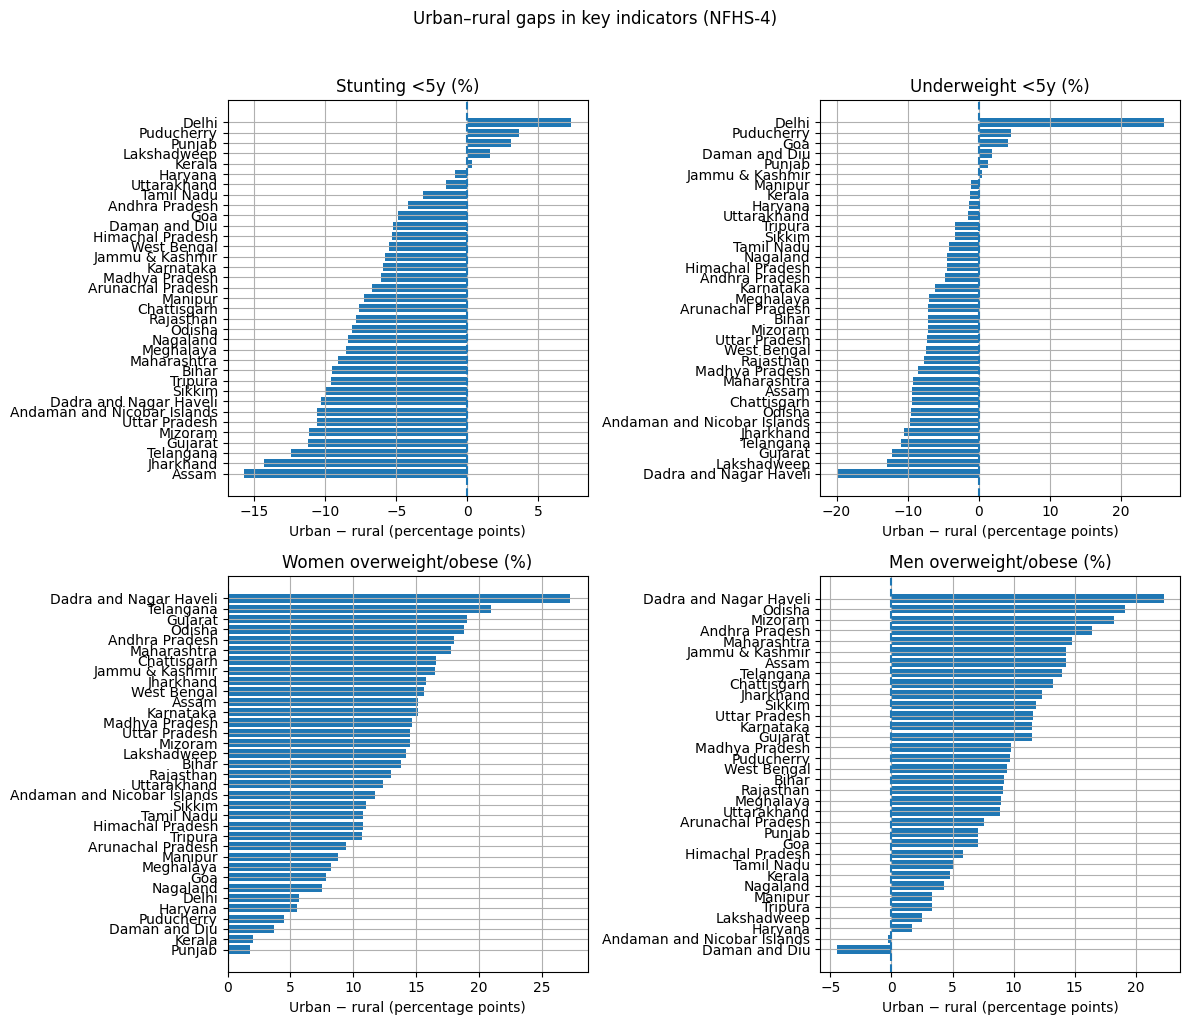

Saved urban–rural gap barplots to: nfhs_outputs_advanced/objective2_urban_rural_gap_barplots.png

=== Correlation of urban–rural gaps ===
                 stunting_gap  underweight_gap  women_bmi_gap  men_bmi_gap
stunting_gap         1.000000         0.565559      -0.570688    -0.389296
underweight_gap      0.565559         1.000000      -0.790505    -0.473381
women_bmi_gap       -0.570688        -0.790505       1.000000     0.742811
men_bmi_gap         -0.389296        -0.473381       0.742811     1.000000



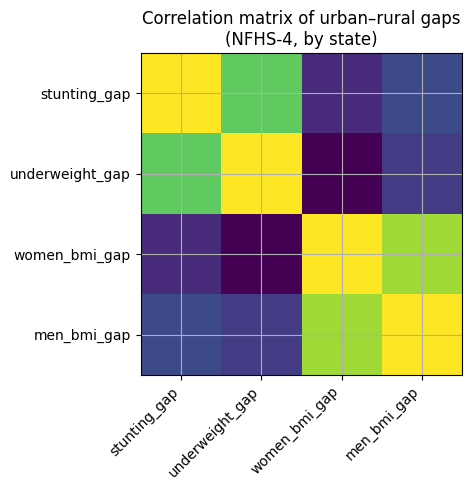

Saved gap correlation heatmap to: nfhs_outputs_advanced/objective2_gap_correlation_heatmap.png

=== PCA explained variance ratios (first 5 PCs) ===
[0.32986386 0.31343574 0.20221805 0.0526874  0.04780421]

Saved PCA loadings to: nfhs_outputs_advanced/objective3_PCA_loadings.csv



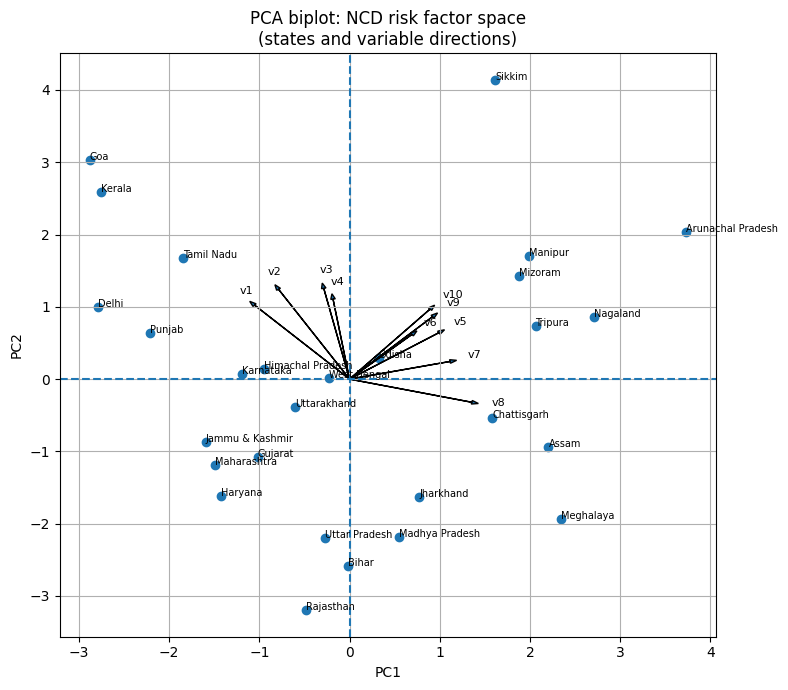

Saved PCA biplot to: nfhs_outputs_advanced/objective3_PCA_biplot.png

Saved PCA variable code map to: nfhs_outputs_advanced/objective3_PCA_variable_codes.csv

=== Regression: SETI_PC1 vs Δ population <15y ===
                            OLS Regression Results                            
Dep. Variable:               SETI_PC1   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     2.700
Date:                Wed, 03 Dec 2025   Prob (F-statistic):              0.112
Time:                        03:53:53   Log-Likelihood:                -55.056
No. Observations:                  28   AIC:                             114.1
Df Residuals:                      26   BIC:                             116.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
 

/tmp/ipython-input-4036621171.py:607: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quart_means = ncd_panel_adv.groupby("delta_under15_quartile")[


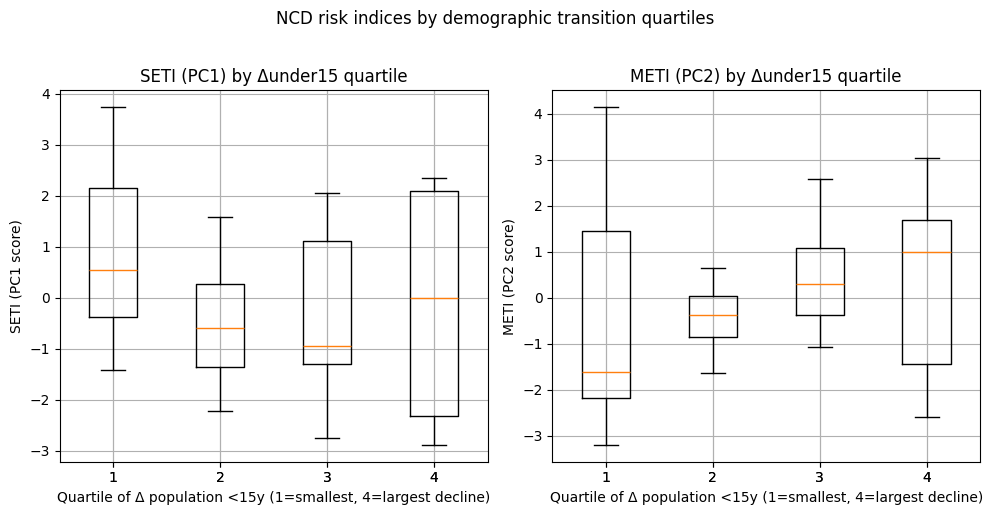

Saved PC1/PC2 quartile boxplots to: nfhs_outputs_advanced/objective3_PC_quartile_boxplots.png

All advanced outputs saved in 'nfhs_outputs_advanced/' and zipped as 'nfhs_outputs_advanced.zip'.


In [3]:
"""
NFHS Advanced Analysis – richer plots and tables
================================================

This script is self-contained:

  * Loads NFHS-3 / NFHS-4 key indicator CSV.
  * Reconstructs:
        - change_clean (state-level change scores)
        - df_ru (state × area × survey panel)
        - ncd_panel + delta_under15
  * Performs:
        1. MANOVA for Δ child outcomes vs Δschool + baselines.
        2. Cluster-robust inequality models.
        3. PCA + PC1/PC2 (SETI + metabolic axis).

  * NEW advanced outputs:
        - Multi-panel regression plots for Objective 1.
        - Heatmap of standardized changes by state.
        - Quartile table by Δschool.
        - Barplots of urban–rural gaps by state.
        - Gap correlation heatmap.
        - PCA biplot (states + NCD variables).
        - Boxplots of PC1/PC2 by Δunder-15 quartiles.
        - Summary tables for all of the above.

Outputs are saved in:
    nfhs_outputs_advanced/
and zipped as:
    nfhs_outputs_advanced.zip

Requirements: pandas, numpy, matplotlib, sklearn, statsmodels.
"""

# --------------------------------------------------
# 0. Imports and setup
# --------------------------------------------------

import os
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.multivariate.manova import MANOVA

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

DATA_PATH = "NFHS-4_NFHS3_Factsheet-All_India_Indicators_R1.csv"
ADV_DIR = "nfhs_outputs_advanced"
os.makedirs(ADV_DIR, exist_ok=True)

# --------------------------------------------------
# 1. Load and basic structure
# --------------------------------------------------

df = pd.read_csv(DATA_PATH)

state_col = "India/States/UTs"
survey_col = "Survey"
area_col = "Area"

print("Data shape:", df.shape)
print("States/UTs:", df[state_col].nunique())
print("Surveys:", df[survey_col].unique())
print("Areas:", df[area_col].unique())
print()

# --------------------------------------------------
# 2. Helper: robust column finder
# --------------------------------------------------

def find_col(pattern):
    """
    Find the (unique) column containing a given substring.
    Raise if none; warn and choose first if multiple.
    """
    matches = [c for c in df.columns if pattern in c]
    if not matches:
        raise ValueError(f"No column matches pattern: '{pattern}'")
    if len(matches) > 1:
        print(f"[WARN] pattern '{pattern}' matched multiple columns; using first:")
        for m in matches:
            print("   ", m)
    return matches[0]

# --------------------------------------------------
# 3. Identify key columns and base subsets
# --------------------------------------------------

# Education and demographic structure
col_female_school = find_col(
    "Population (female) age 6 years and above who ever attended school"
)
col_pop_under15 = find_col("Population below age 15 years")

# Child nutrition & mortality
col_stunted      = find_col("Children under 5 years who are stunted (height-for-age)")
col_wasted       = find_col("Children under 5 years who are wasted (weight-for-height)")
col_underweight  = find_col("Children under 5 years who are underweight (weight-for-age)")
col_u5mr         = find_col("Under-five mortality rate (U5MR)")

# Adult NCD indicators
col_women_bmi_high = find_col(
    "Nutritional Status of Adults (age 15-49 years) - Women who are overweight or obese"
)
col_men_bmi_high   = find_col(
    "Nutritional Status of Adults (age 15-49 years) - Men who are overweight or obese"
)
col_w_bg_high      = find_col("Women - Blood sugar level - high (>140 mg/dl)")
col_m_bg_high      = find_col("Men - Blood sugar level - high (>140 mg/dl)")
col_w_bp_very      = find_col("Women - Very high (Systolic >=")
col_m_bp_very      = find_col("Men - Very high (Systolic >=")
col_w_tobacco      = find_col("Women who use any kind of tobacco")
col_m_tobacco      = find_col("Men who use any kind of tobacco")
col_w_alcohol      = find_col("Women who consume alcohol")
col_m_alcohol      = find_col("Men who consume alcohol")

ncd_cols = [
    col_women_bmi_high,
    col_men_bmi_high,
    col_w_bg_high,
    col_m_bg_high,
    col_w_bp_very,
    col_m_bp_very,
    col_w_tobacco,
    col_m_tobacco,
    col_w_alcohol,
    col_m_alcohol,
]

print("Selected core columns:")
for c in [
    col_female_school,
    col_pop_under15,
    col_stunted,
    col_wasted,
    col_underweight,
    col_u5mr,
]:
    print("  ", c)
print("\nSelected NCD columns:")
for c in ncd_cols:
    print("  ", c)
print()

# Subsets
df_states = df[df[state_col] != "India"].copy()
df_states_total = df_states[df_states[area_col] == "Total"].copy()
df_states_ru = df_states[df_states[area_col].isin(["Rural", "Urban"])].copy()

# --------------------------------------------------
# 4. Reconstruct change_clean (Objective 1)
# --------------------------------------------------

def pivot_total(colname):
    return df_states_total.pivot(index=state_col, columns=survey_col, values=colname)

school_wide = pivot_total(col_female_school)
stunt_wide  = pivot_total(col_stunted)
waste_wide  = pivot_total(col_wasted)
under_wide  = pivot_total(col_underweight)
u5mr_wide   = pivot_total(col_u5mr)

change_df = pd.DataFrame(
    {
        "state": school_wide.index,
        "d_school":        school_wide["NFHS-4"] - school_wide["NFHS-3"],
        "d_stunting":      stunt_wide["NFHS-4"]  - stunt_wide["NFHS-3"],
        "d_wasting":       waste_wide["NFHS-4"]  - waste_wide["NFHS-3"],
        "d_underweight":   under_wide["NFHS-4"]  - under_wide["NFHS-3"],
        "d_u5mr":          u5mr_wide["NFHS-4"]   - u5mr_wide["NFHS-3"],
        "stunting_baseline":    stunt_wide["NFHS-3"],
        "wasting_baseline":     waste_wide["NFHS-3"],
        "underweight_baseline": under_wide["NFHS-3"],
        "u5mr_baseline":        u5mr_wide["NFHS-3"],
    }
)
change_clean = change_df.dropna().reset_index(drop=True)

print("change_clean shape:", change_clean.shape)
print(change_clean.head())
print()

change_clean.to_csv(os.path.join(ADV_DIR, "change_clean_full.csv"), index=False)

# --------------------------------------------------
# 5. Reconstruct df_ru (Objective 2)
# --------------------------------------------------

df_ru = df_states_ru[df_states_ru[survey_col].isin(["NFHS-3", "NFHS-4"])].copy()
df_ru["state"] = df_ru[state_col]
df_ru["area_bin"] = (df_ru[area_col] == "Urban").astype(int)
df_ru["survey_num"] = (df_ru[survey_col] == "NFHS-4").astype(int)

print("df_ru shape:", df_ru.shape)
print(df_ru[[state_col, area_col, survey_col, "area_bin", "survey_num"]].head())
print()

# --------------------------------------------------
# 6. Reconstruct ncd_panel + demo_wide (Objective 3)
# --------------------------------------------------

demo_wide = pivot_total(col_pop_under15)
demo_wide["delta_under15"] = demo_wide["NFHS-4"] - demo_wide["NFHS-3"]

states_total_nfhs4 = df_states_total[df_states_total[survey_col] == "NFHS-4"].copy()
ncd_panel = states_total_nfhs4[[state_col] + ncd_cols].copy()

ncd_panel = ncd_panel.merge(
    demo_wide[["delta_under15"]],
    left_on=state_col,
    right_index=True,
    how="left",
)

ncd_panel = ncd_panel.dropna(subset=["delta_under15"]).reset_index(drop=True)

print("ncd_panel shape:", ncd_panel.shape)
print(ncd_panel.head())
print()

ncd_panel.to_csv(os.path.join(ADV_DIR, "ncd_panel_full.csv"), index=False)

# ==================================================
# 7. Objective 1 – MANOVA + advanced plots/tables
# ==================================================

# 7.1 MANOVA
manova_df = change_clean[[
    "d_stunting",
    "d_underweight",
    "d_u5mr",
    "d_school",
    "stunting_baseline",
    "wasting_baseline",
    "underweight_baseline",
    "u5mr_baseline",
]].dropna()

print("MANOVA dataframe shape:", manova_df.shape)
print()

manova_formula = (
    "d_stunting + d_underweight + d_u5mr "
    "~ d_school + stunting_baseline + wasting_baseline + "
    "underweight_baseline + u5mr_baseline"
)
manova = MANOVA.from_formula(manova_formula, data=manova_df)
manova_results = manova.mv_test()

print("=== MANOVA results for (Δ stunting, Δ underweight, Δ U5MR) ===")
print(manova_results)
print()

with open(os.path.join(ADV_DIR, "objective1_MANOVA_results.txt"), "w") as f:
    f.write(str(manova_results))

# 7.2 Multi-panel regression plots
import itertools

outcome_specs = [
    ("d_stunting",     "Δ Stunting (%)"),
    ("d_wasting",      "Δ Wasting (%)"),
    ("d_underweight",  "Δ Underweight (%)"),
    ("d_u5mr",         "Δ U5MR (per 1000)"),
]

ols_models = {}
for y_col, _label in outcome_specs:
    X = change_clean[["d_school", y_col.replace("d_", "") + "_baseline"]] \
        if y_col != "d_u5mr" else change_clean[["d_school", "u5mr_baseline"]]
    # For simplicity: adjust olny by baseline
    base_col = y_col.replace("d_", "") + "_baseline"
    if y_col == "d_u5mr":
        base_col = "u5mr_baseline"
    X = change_clean[["d_school", base_col]]
    X = sm.add_constant(X)
    y = change_clean[y_col]
    model = sm.OLS(y, X).fit()
    ols_models[y_col] = model

fig, axes = plt.subplots(2, 2, figsize=(11, 8), sharex=True)
axes = axes.flatten()

for ax, (y_col, label) in zip(axes, outcome_specs):
    x = change_clean["d_school"].values
    y = change_clean[y_col].values

    ax.scatter(x, y)

    # Simple regression line (y ~ x)
    coef = np.polyfit(x, y, 1)
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = coef[0] * x_line + coef[1]
    ax.plot(x_line, y_line)

    model = ols_models[y_col]
    r2 = model.rsquared
    p = model.pvalues["d_school"]

    ax.set_title(label)
    ax.set_xlabel("Δ Female schooling (pp)")
    ax.set_ylabel(label)
    ax.text(
        0.05, 0.95,
        f"R²={r2:.2f}, p={p:.3f}",
        transform=ax.transAxes,
        va="top",
        ha="left"
    )

fig.suptitle("Δ Female schooling vs Δ child outcomes (state-level, Total area)", y=1.02)
fig.tight_layout()
adv_fig1_path = os.path.join(ADV_DIR, "objective1_multi_panel_regressions.png")
plt.savefig(adv_fig1_path)
plt.show()
print("Saved multi-panel regression figure to:", adv_fig1_path)
print()

# 7.3 Heatmap of standardized changes by state
heat_cols = ["d_school", "d_stunting", "d_underweight", "d_u5mr"]
Z = change_clean[heat_cols].copy()
Z_std = (Z - Z.mean()) / Z.std()

fig, ax = plt.subplots(figsize=(9, 10))
im = ax.imshow(Z_std.values, aspect="auto")

ax.set_yticks(range(len(change_clean)))
ax.set_yticklabels(change_clean["state"].tolist())
ax.set_xticks(range(len(heat_cols)))
ax.set_xticklabels(["ΔSchool", "ΔStunt", "ΔUnderwt", "ΔU5MR"], rotation=45, ha="right")

ax.set_title("Standardized changes in education and child outcomes\n(NFHS-4 minus NFHS-3, by state)")
fig.tight_layout()
heatmap_path = os.path.join(ADV_DIR, "objective1_state_change_heatmap.png")
plt.savefig(heatmap_path)
plt.show()
print("Saved heatmap to:", heatmap_path)
print()

Z_std.to_csv(os.path.join(ADV_DIR, "objective1_state_change_heatmap_data.csv"), index=False)

# 7.4 Quartile table by Δschool
change_quart = change_clean.copy()
change_quart["school_quartile"] = pd.qcut(change_quart["d_school"], 4, labels=[1, 2, 3, 4])

quart_summary = change_quart.groupby("school_quartile")[
    ["d_stunting", "d_wasting", "d_underweight", "d_u5mr"]
].mean()

print("=== Quartile summary by Δschool (mean changes) ===")
print(quart_summary)
print()

quart_csv_path = os.path.join(ADV_DIR, "objective1_quartile_summary.csv")
quart_summary.to_csv(quart_csv_path)
print("Saved quartile summary to:", quart_csv_path)
print()

# ==================================================
# 8. Objective 2 – Cluster-robust FE + advanced gap plots
# ==================================================

ineq_indicators = {
    "stunting":       col_stunted,
    "underweight":    col_underweight,
    "women_bmi_high": col_women_bmi_high,
    "men_bmi_high":   col_men_bmi_high,
}

ineq_cluster_rows = []
gap_tables = {}

for short_name, col in ineq_indicators.items():
    df_i = df_ru[["state", area_col, survey_col, "area_bin", "survey_num", col]].dropna().copy()
    df_i = df_i.rename(columns={col: "value"})

    # Cluster-robust FE model
    formula = "value ~ area_bin * survey_num + C(state)"
    model_cluster = smf.ols(formula, data=df_i).fit(
        cov_type="cluster",
        cov_kwds={"groups": df_i["state"]}
    )

    params = model_cluster.params
    conf   = model_cluster.conf_int()

    def safe_get(name):
        return (
            params.get(name, np.nan),
            conf.loc[name, 0] if name in conf.index else np.nan,
            conf.loc[name, 1] if name in conf.index else np.nan,
            model_cluster.pvalues.get(name, np.nan),
        )

    coef_area,   ci_lo_area,   ci_hi_area,   p_area   = safe_get("area_bin")
    coef_survey, ci_lo_survey, ci_hi_survey, p_survey = safe_get("survey_num")
    coef_int,    ci_lo_int,    ci_hi_int,    p_int    = safe_get("area_bin:survey_num")

    ineq_cluster_rows.append({
        "indicator": short_name,
        "n_obs": int(model_cluster.nobs),
        "coef_area_bin": coef_area,
        "ci_area_low": ci_lo_area,
        "ci_area_high": ci_hi_area,
        "p_area_bin": p_area,
        "coef_survey_num": coef_survey,
        "ci_survey_low": ci_lo_survey,
        "ci_survey_high": ci_hi_survey,
        "p_survey_num": p_survey,
        "coef_area_survey_interaction": coef_int,
        "ci_inter_low": ci_lo_int,
        "ci_inter_high": ci_hi_int,
        "p_interaction": p_int,
        "R2": model_cluster.rsquared,
    })

    print(f"=== Cluster-robust FE model for {short_name} ===")
    print(model_cluster.summary())
    print()

    # Compute urban–rural gaps by state for NFHS-4 only
    nfhs4 = df_i[df_i[survey_col] == "NFHS-4"].copy()
    wide_nfhs4 = nfhs4.pivot(index="state", columns=area_col, values="value")
    wide_nfhs4["urban_minus_rural"] = wide_nfhs4.get("Urban", np.nan) - wide_nfhs4.get("Rural", np.nan)
    gap_tables[short_name] = wide_nfhs4[["urban_minus_rural"]].dropna()

ineq_cluster_table = pd.DataFrame(ineq_cluster_rows)
print("=== Cluster-robust inequality summary (all indicators) ===")
print(ineq_cluster_table)
print()

cluster_csv_path = os.path.join(ADV_DIR, "objective2_inequality_cluster_summary.csv")
ineq_cluster_table.to_csv(cluster_csv_path, index=False)
print("Saved cluster-robust summary to:", cluster_csv_path)
print()

# 8.1 Barplots of gaps by state (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

pretty_names = {
    "stunting": "Stunting <5y (%)",
    "underweight": "Underweight <5y (%)",
    "women_bmi_high": "Women overweight/obese (%)",
    "men_bmi_high": "Men overweight/obese (%)",
}

for ax, key in zip(axes, ["stunting", "underweight", "women_bmi_high", "men_bmi_high"]):
    gaps = gap_tables[key].copy()
    gaps_sorted = gaps.sort_values("urban_minus_rural")
    ax.barh(gaps_sorted.index, gaps_sorted["urban_minus_rural"])
    ax.axvline(0, linestyle="--")
    ax.set_title(pretty_names[key])
    ax.set_xlabel("Urban − rural (percentage points)")

fig.suptitle("Urban–rural gaps in key indicators (NFHS-4)", y=1.02)
fig.tight_layout()
gap_bar_path = os.path.join(ADV_DIR, "objective2_urban_rural_gap_barplots.png")
plt.savefig(gap_bar_path)
plt.show()
print("Saved urban–rural gap barplots to:", gap_bar_path)
print()

# 8.2 Correlation heatmap of gaps
gap_matrix = pd.DataFrame({
    "stunting_gap":      gap_tables["stunting"]["urban_minus_rural"],
    "underweight_gap":   gap_tables["underweight"]["urban_minus_rural"],
    "women_bmi_gap":     gap_tables["women_bmi_high"]["urban_minus_rural"],
    "men_bmi_gap":       gap_tables["men_bmi_high"]["urban_minus_rural"],
}).dropna()

gap_corr = gap_matrix.corr()
print("=== Correlation of urban–rural gaps ===")
print(gap_corr)
print()

gap_corr.to_csv(os.path.join(ADV_DIR, "objective2_gap_correlation_matrix.csv"))

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(gap_corr.values)
ax.set_xticks(range(len(gap_corr.columns)))
ax.set_xticklabels(gap_corr.columns, rotation=45, ha="right")
ax.set_yticks(range(len(gap_corr.index)))
ax.set_yticklabels(gap_corr.index)
ax.set_title("Correlation matrix of urban–rural gaps\n(NFHS-4, by state)")
fig.tight_layout()
gap_corr_path = os.path.join(ADV_DIR, "objective2_gap_correlation_heatmap.png")
plt.savefig(gap_corr_path)
plt.show()
print("Saved gap correlation heatmap to:", gap_corr_path)
print()

# ==================================================
# 9. Objective 3 – PCA biplot + Δ-under15 stratification
# ==================================================

# PCA on NCD indicators
scaler2 = StandardScaler()
Z2 = scaler2.fit_transform(ncd_panel[ncd_cols])

pca2 = PCA()
scores2 = pca2.fit_transform(Z2)

ncd_panel_adv = ncd_panel.copy()
ncd_panel_adv["SETI_PC1"] = scores2[:, 0]
ncd_panel_adv["METI_PC2"] = scores2[:, 1]

print("=== PCA explained variance ratios (first 5 PCs) ===")
print(pca2.explained_variance_ratio_[:5])
print()

pca2_loadings = pd.DataFrame(
    pca2.components_.T,
    index=ncd_cols,
    columns=[f"PC{j+1}" for j in range(len(ncd_cols))]
)
pca2_loadings_path = os.path.join(ADV_DIR, "objective3_PCA_loadings.csv")
pca2_loadings.to_csv(pca2_loadings_path)
print("Saved PCA loadings to:", pca2_loadings_path)
print()

# 9.1 PCA biplot (PC1 vs PC2, with variable arrows)
pc1 = scores2[:, 0]
pc2 = scores2[:, 1]
loadings = pca2.components_.T[:, :2]

fig, ax = plt.subplots(figsize=(8, 7))

# Scores (states)
ax.scatter(pc1, pc2)
for i, sname in enumerate(ncd_panel_adv[state_col]):
    ax.text(pc1[i], pc2[i], sname, fontsize=7)

# Variable arrows
# Scale arrows to improve visibility
arrow_scale = 3.0
for i, var in enumerate(ncd_cols):
    ax.arrow(0, 0, loadings[i, 0] * arrow_scale, loadings[i, 1] * arrow_scale,
             head_width=0.05, length_includes_head=True)
    ax.text(loadings[i, 0] * arrow_scale * 1.1,
            loadings[i, 1] * arrow_scale * 1.1,
            f"v{i+1}", fontsize=8)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("PCA biplot: NCD risk factor space\n(states and variable directions)")
ax.axhline(0, linestyle="--")
ax.axvline(0, linestyle="--")
fig.tight_layout()
biplot_path = os.path.join(ADV_DIR, "objective3_PCA_biplot.png")
plt.savefig(biplot_path)
plt.show()
print("Saved PCA biplot to:", biplot_path)
print()

# Save mapping of v1..v10 to actual indicator names
var_map = pd.DataFrame({
    "code": [f"v{i+1}" for i in range(len(ncd_cols))],
    "indicator": ncd_cols,
})
varmap_path = os.path.join(ADV_DIR, "objective3_PCA_variable_codes.csv")
var_map.to_csv(varmap_path, index=False)
print("Saved PCA variable code map to:", varmap_path)
print()

# 9.2 Regressions: PC1 and PC2 vs Δunder15
X_dem = sm.add_constant(ncd_panel_adv["delta_under15"])
model_pc1 = sm.OLS(ncd_panel_adv["SETI_PC1"], X_dem).fit()
model_pc2 = sm.OLS(ncd_panel_adv["METI_PC2"], X_dem).fit()

print("=== Regression: SETI_PC1 vs Δ population <15y ===")
print(model_pc1.summary())
print()
print("=== Regression: METI_PC2 vs Δ population <15y ===")
print(model_pc2.summary())
print()

reg_pc1 = pd.DataFrame({
    "coef": model_pc1.params,
    "p_value": model_pc1.pvalues,
    "ci_low": model_pc1.conf_int()[0],
    "ci_high": model_pc1.conf_int()[1],
})
reg_pc2 = pd.DataFrame({
    "coef": model_pc2.params,
    "p_value": model_pc2.pvalues,
    "ci_low": model_pc2.conf_int()[0],
    "ci_high": model_pc2.conf_int()[1],
})
reg_pc1.to_csv(os.path.join(ADV_DIR, "objective3_reg_SETI_PC1.csv"))
reg_pc2.to_csv(os.path.join(ADV_DIR, "objective3_reg_METI_PC2.csv"))

# 9.3 Stratify by Δunder15 quartiles and boxplots
ncd_panel_adv["delta_under15_quartile"] = pd.qcut(
    ncd_panel_adv["delta_under15"], 4, labels=[1, 2, 3, 4]
)

quart_means = ncd_panel_adv.groupby("delta_under15_quartile")[
    ["SETI_PC1", "METI_PC2", "delta_under15"]
].mean()

print("=== Mean PC1/PC2 by Δunder15 quartile ===")
print(quart_means)
print()

quart_means.to_csv(os.path.join(ADV_DIR, "objective3_PC_quartile_means.csv"))

# Boxplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

# Prepare data for boxplots
groups = [ncd_panel_adv[ncd_panel_adv["delta_under15_quartile"] == q]["SETI_PC1"]
          for q in [1, 2, 3, 4]]
axes[0].boxplot(groups)
axes[0].set_title("SETI (PC1) by Δunder15 quartile")
axes[0].set_xlabel("Quartile of Δ population <15y (1=smallest, 4=largest decline)")
axes[0].set_ylabel("SETI (PC1 score)")

groups2 = [ncd_panel_adv[ncd_panel_adv["delta_under15_quartile"] == q]["METI_PC2"]
           for q in [1, 2, 3, 4]]
axes[1].boxplot(groups2)
axes[1].set_title("METI (PC2) by Δunder15 quartile")
axes[1].set_xlabel("Quartile of Δ population <15y (1=smallest, 4=largest decline)")
axes[1].set_ylabel("METI (PC2 score)")

fig.suptitle("NCD risk indices by demographic transition quartiles", y=1.02)
fig.tight_layout()
boxplot_path = os.path.join(ADV_DIR, "objective3_PC_quartile_boxplots.png")
plt.savefig(boxplot_path)
plt.show()
print("Saved PC1/PC2 quartile boxplots to:", boxplot_path)
print()

# ==================================================
# 10. Zip all advanced outputs
# ==================================================

zip_path = "nfhs_outputs_advanced.zip"
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for root, dirs, files in os.walk(ADV_DIR):
        for fname in files:
            full_path = os.path.join(root, fname)
            arcname = os.path.relpath(full_path, ADV_DIR)
            z.write(full_path, arcname=arcname)

print(f"All advanced outputs saved in '{ADV_DIR}/' and zipped as '{zip_path}'.")


Data shape: (148, 192)
States/UTs: 37
Surveys: ['NFHS-4' 'NFHS-3']
Areas: ['Total' 'Rural' 'Urban']

[WARN] pattern 'Under-five mortality rate (U5MR)' matched multiple columns; using first:
    Infant and Child Mortality Rates (per 1000 live births) - Under-five mortality rate (U5MR)
    Note of : Infant and Child Mortality Rates (per 1000 live births) - Under-five mortality rate (U5MR)
[WARN] pattern 'Nutritional Status of Adults (age 15-49 years) - Men who are overweight or obese' matched multiple columns; using first:
    Nutritional Status of Adults (age 15-49 years) - Men who are overweight or obese (BMI >= 25.0 kg/m2) (%)
    Note of : Nutritional Status of Adults (age 15-49 years) - Men who are overweight or obese (BMI >= 25.0 kg/m2) (%)
[WARN] pattern 'Women - Blood sugar level - high (>140 mg/dl)' matched multiple columns; using first:
    Women - Blood sugar level - high (>140 mg/dl) (%)
    Note of : Women - Blood sugar level - high (>140 mg/dl) (%)
[WARN] pattern 'Men - Blo

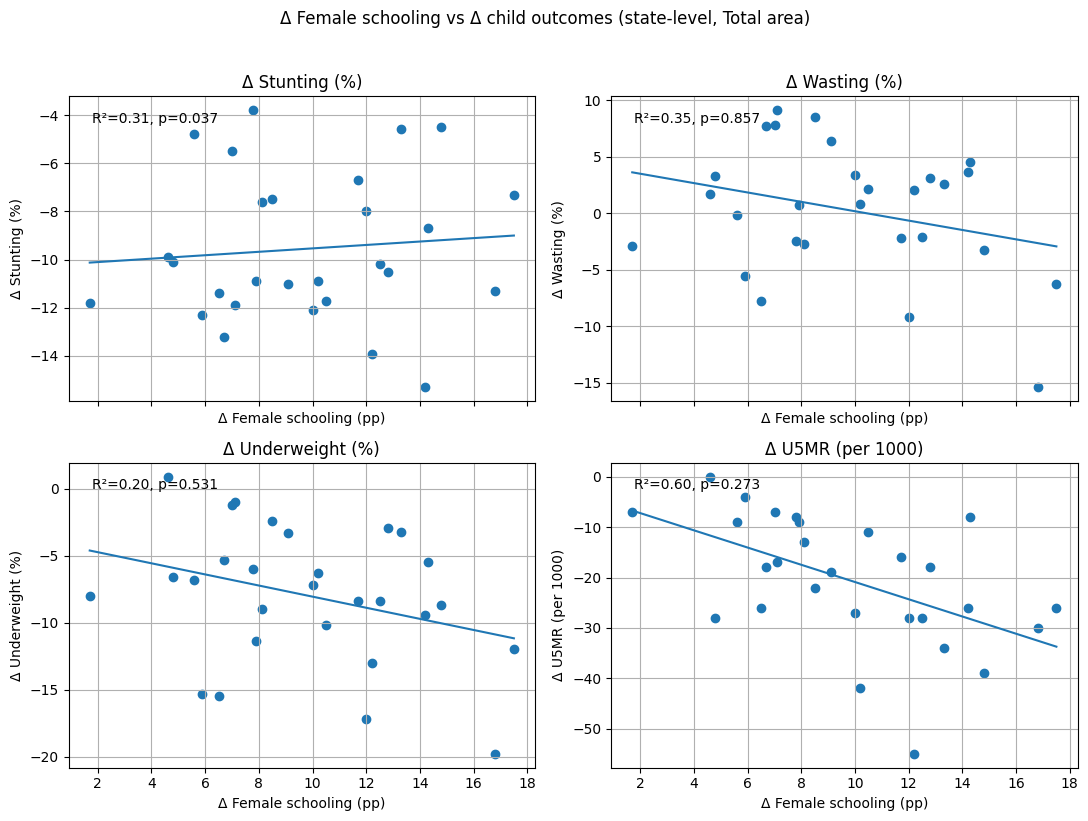

Saved multi-panel regression figure to: nfhs_outputs_advanced/objective1_multi_panel_regressions.png



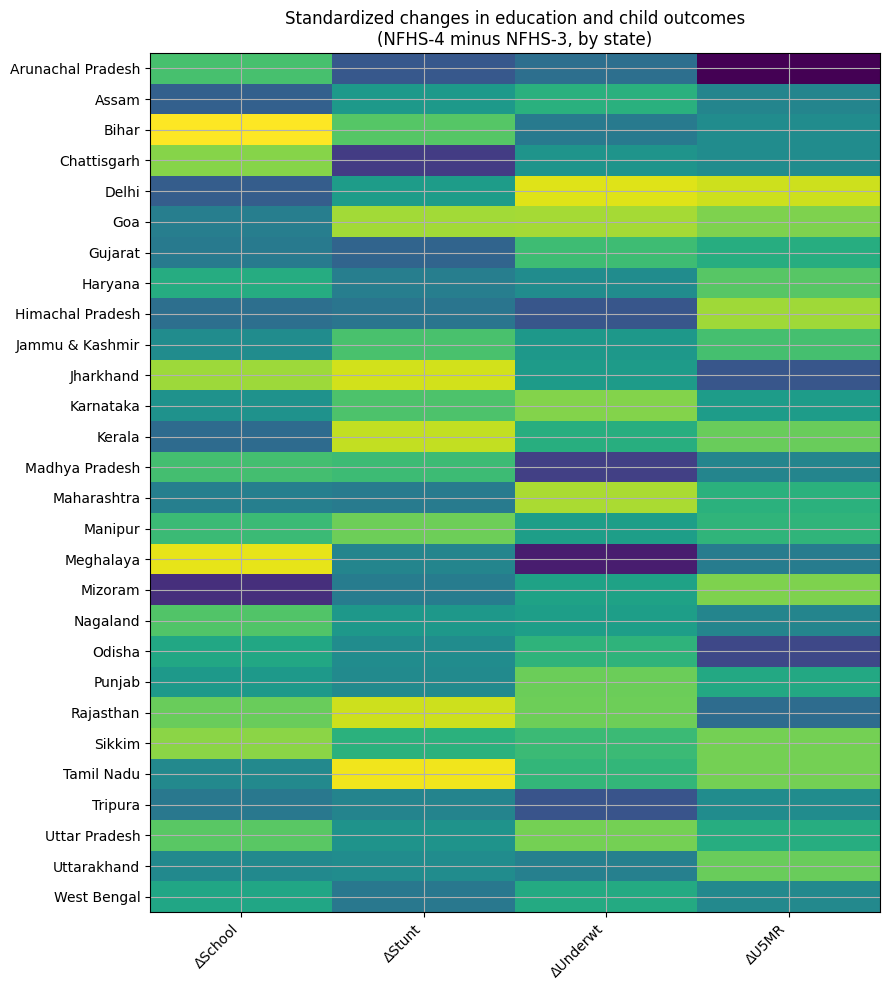

Saved heatmap to: nfhs_outputs_advanced/objective1_state_change_heatmap.png

=== Quartile summary by Δschool (mean changes) ===
                 d_stunting  d_wasting  d_underweight     d_u5mr
school_quartile                                                 
1                -10.500000  -0.542857      -8.085714 -13.142857
2                 -8.314286   3.900000      -4.900000 -13.571429
3                -10.500000  -0.742857     -10.100000 -29.571429
4                 -8.885714  -1.600000      -8.785714 -25.857143

Saved quartile summary to: nfhs_outputs_advanced/objective1_quartile_summary.csv

=== Cluster-robust FE model for stunting ===
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     78.37
Date:                Wed, 03 Dec 2025 

/tmp/ipython-input-4036621171.py:355: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quart_summary = change_quart.groupby("school_quartile")[
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 37, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 37, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 37, b

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     13.74
Date:                Wed, 03 Dec 2025   Prob (F-statistic):           0.000744
Time:                        04:00:41   Log-Likelihood:                -170.84
No. Observations:                  70   AIC:                             413.7
Df Residuals:                      34   BIC:                             494.6
Df Model:                          35                                         
Covariance Type:              cluster                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 37, but rank is 1
  warnings.warn('covariance of constraints does not have full '


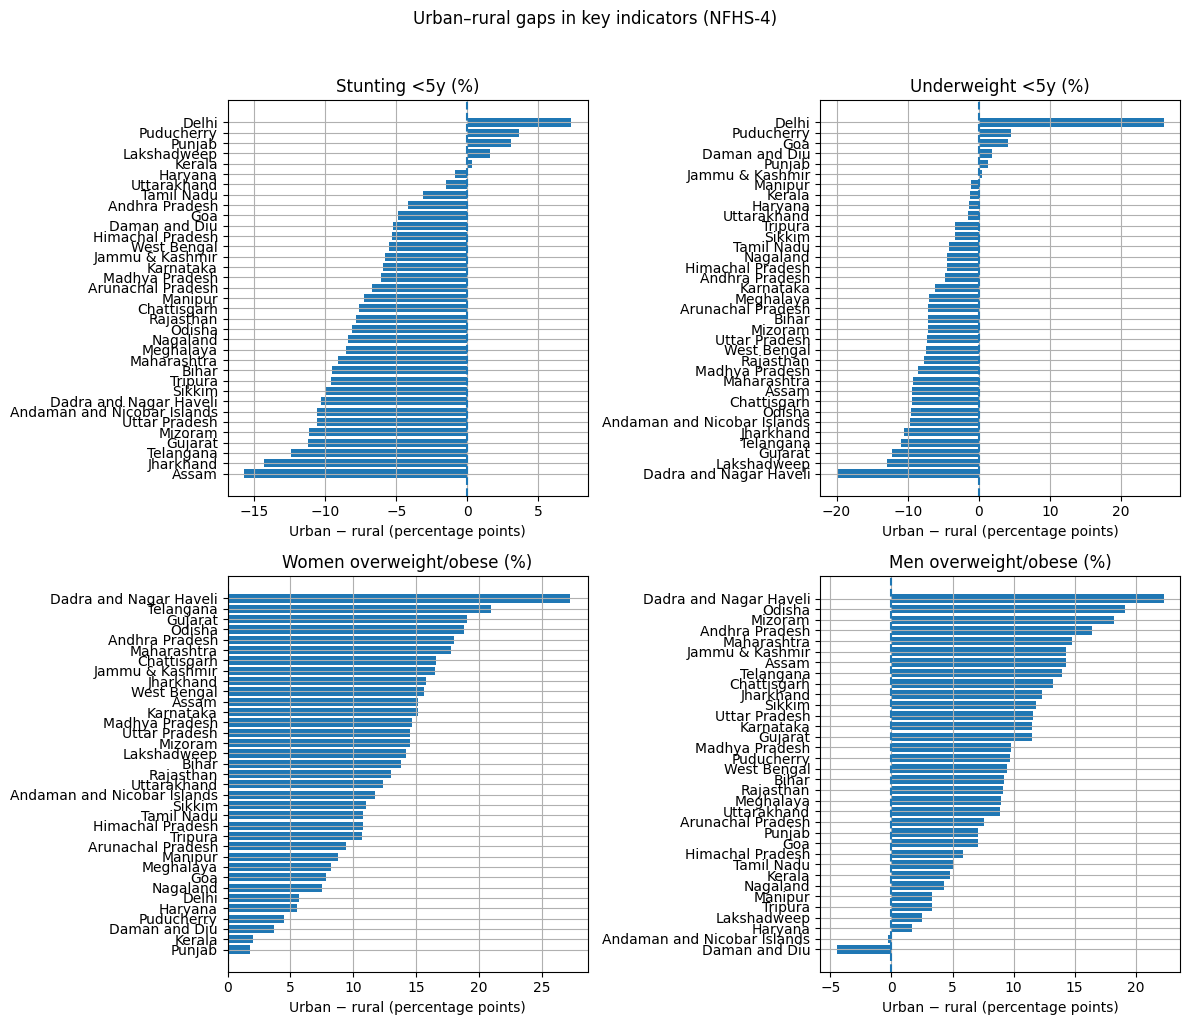

Saved urban–rural gap barplots to: nfhs_outputs_advanced/objective2_urban_rural_gap_barplots.png

=== Correlation of urban–rural gaps ===
                 stunting_gap  underweight_gap  women_bmi_gap  men_bmi_gap
stunting_gap         1.000000         0.565559      -0.570688    -0.389296
underweight_gap      0.565559         1.000000      -0.790505    -0.473381
women_bmi_gap       -0.570688        -0.790505       1.000000     0.742811
men_bmi_gap         -0.389296        -0.473381       0.742811     1.000000



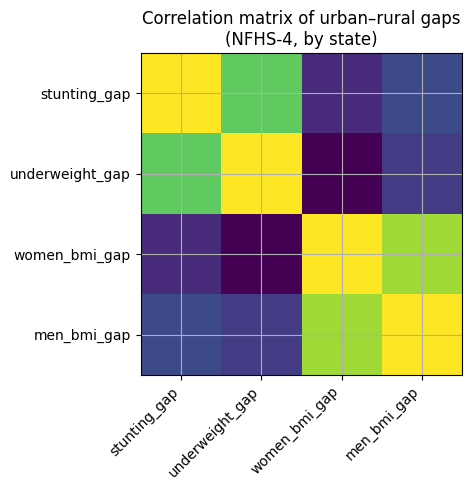

Saved gap correlation heatmap to: nfhs_outputs_advanced/objective2_gap_correlation_heatmap.png

=== PCA explained variance ratios (first 5 PCs) ===
[0.32986386 0.31343574 0.20221805 0.0526874  0.04780421]

Saved PCA loadings to: nfhs_outputs_advanced/objective3_PCA_loadings.csv



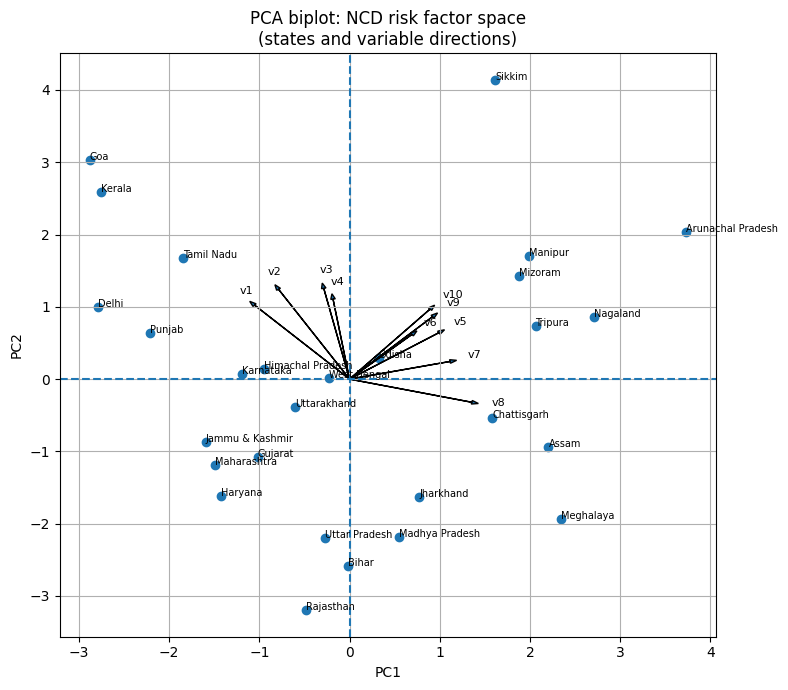

Saved PCA biplot to: nfhs_outputs_advanced/objective3_PCA_biplot.png

Saved PCA variable code map to: nfhs_outputs_advanced/objective3_PCA_variable_codes.csv

=== Regression: SETI_PC1 vs Δ population <15y ===
                            OLS Regression Results                            
Dep. Variable:               SETI_PC1   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     2.700
Date:                Wed, 03 Dec 2025   Prob (F-statistic):              0.112
Time:                        04:00:49   Log-Likelihood:                -55.056
No. Observations:                  28   AIC:                             114.1
Df Residuals:                      26   BIC:                             116.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
 

/tmp/ipython-input-4036621171.py:607: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quart_means = ncd_panel_adv.groupby("delta_under15_quartile")[


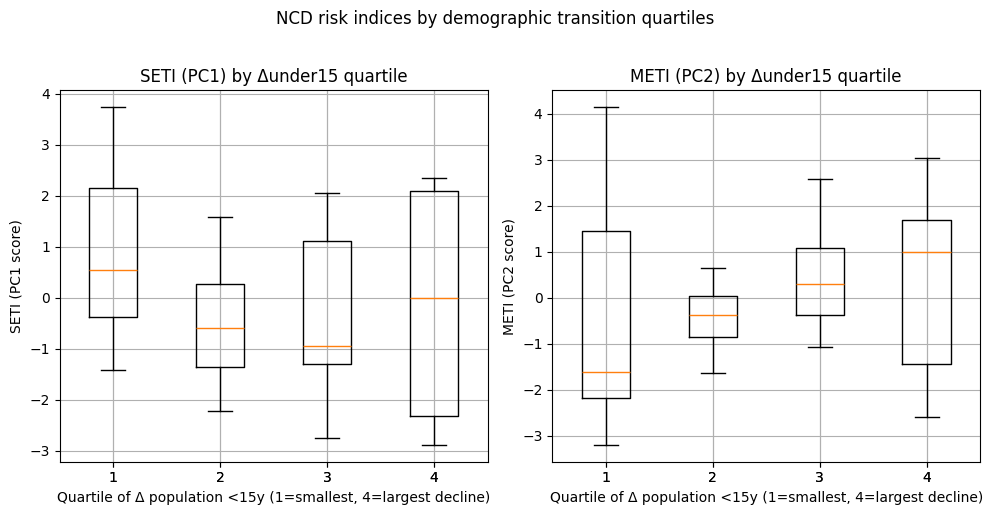

Saved PC1/PC2 quartile boxplots to: nfhs_outputs_advanced/objective3_PC_quartile_boxplots.png

All advanced outputs saved in 'nfhs_outputs_advanced/' and zipped as 'nfhs_outputs_advanced.zip'.


In [5]:
"""
NFHS Advanced Analysis – richer plots and tables
================================================

This script is self-contained:

  * Loads NFHS-3 / NFHS-4 key indicator CSV.
  * Reconstructs:
        - change_clean (state-level change scores)
        - df_ru (state × area × survey panel)
        - ncd_panel + delta_under15
  * Performs:
        1. MANOVA for Δ child outcomes vs Δschool + baselines.
        2. Cluster-robust inequality models.
        3. PCA + PC1/PC2 (SETI + metabolic axis).

  * NEW advanced outputs:
        - Multi-panel regression plots for Objective 1.
        - Heatmap of standardized changes by state.
        - Quartile table by Δschool.
        - Barplots of urban–rural gaps by state.
        - Gap correlation heatmap.
        - PCA biplot (states + NCD variables).
        - Boxplots of PC1/PC2 by Δunder-15 quartiles.
        - Summary tables for all of the above.

Outputs are saved in:
    nfhs_outputs_advanced/
and zipped as:
    nfhs_outputs_advanced.zip

Requirements: pandas, numpy, matplotlib, sklearn, statsmodels.
"""

# --------------------------------------------------
# 0. Imports and setup
# --------------------------------------------------

import os
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.multivariate.manova import MANOVA

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

DATA_PATH = "NFHS-4_NFHS3_Factsheet-All_India_Indicators_R1.csv"
ADV_DIR = "nfhs_outputs_advanced"
os.makedirs(ADV_DIR, exist_ok=True)

# --------------------------------------------------
# 1. Load and basic structure
# --------------------------------------------------

df = pd.read_csv(DATA_PATH)

state_col = "India/States/UTs"
survey_col = "Survey"
area_col = "Area"

print("Data shape:", df.shape)
print("States/UTs:", df[state_col].nunique())
print("Surveys:", df[survey_col].unique())
print("Areas:", df[area_col].unique())
print()

# --------------------------------------------------
# 2. Helper: robust column finder
# --------------------------------------------------

def find_col(pattern):
    """
    Find the (unique) column containing a given substring.
    Raise if none; warn and choose first if multiple.
    """
    matches = [c for c in df.columns if pattern in c]
    if not matches:
        raise ValueError(f"No column matches pattern: '{pattern}'")
    if len(matches) > 1:
        print(f"[WARN] pattern '{pattern}' matched multiple columns; using first:")
        for m in matches:
            print("   ", m)
    return matches[0]

# --------------------------------------------------
# 3. Identify key columns and base subsets
# --------------------------------------------------

# Education and demographic structure
col_female_school = find_col(
    "Population (female) age 6 years and above who ever attended school"
)
col_pop_under15 = find_col("Population below age 15 years")

# Child nutrition & mortality
col_stunted      = find_col("Children under 5 years who are stunted (height-for-age)")
col_wasted       = find_col("Children under 5 years who are wasted (weight-for-height)")
col_underweight  = find_col("Children under 5 years who are underweight (weight-for-age)")
col_u5mr         = find_col("Under-five mortality rate (U5MR)")

# Adult NCD indicators
col_women_bmi_high = find_col(
    "Nutritional Status of Adults (age 15-49 years) - Women who are overweight or obese"
)
col_men_bmi_high   = find_col(
    "Nutritional Status of Adults (age 15-49 years) - Men who are overweight or obese"
)
col_w_bg_high      = find_col("Women - Blood sugar level - high (>140 mg/dl)")
col_m_bg_high      = find_col("Men - Blood sugar level - high (>140 mg/dl)")
col_w_bp_very      = find_col("Women - Very high (Systolic >=")
col_m_bp_very      = find_col("Men - Very high (Systolic >=")
col_w_tobacco      = find_col("Women who use any kind of tobacco")
col_m_tobacco      = find_col("Men who use any kind of tobacco")
col_w_alcohol      = find_col("Women who consume alcohol")
col_m_alcohol      = find_col("Men who consume alcohol")

ncd_cols = [
    col_women_bmi_high,
    col_men_bmi_high,
    col_w_bg_high,
    col_m_bg_high,
    col_w_bp_very,
    col_m_bp_very,
    col_w_tobacco,
    col_m_tobacco,
    col_w_alcohol,
    col_m_alcohol,
]

print("Selected core columns:")
for c in [
    col_female_school,
    col_pop_under15,
    col_stunted,
    col_wasted,
    col_underweight,
    col_u5mr,
]:
    print("  ", c)
print("\nSelected NCD columns:")
for c in ncd_cols:
    print("  ", c)
print()

# Subsets
df_states = df[df[state_col] != "India"].copy()
df_states_total = df_states[df_states[area_col] == "Total"].copy()
df_states_ru = df_states[df_states[area_col].isin(["Rural", "Urban"])].copy()

# --------------------------------------------------
# 4. Reconstruct change_clean (Objective 1)
# --------------------------------------------------

def pivot_total(colname):
    return df_states_total.pivot(index=state_col, columns=survey_col, values=colname)

school_wide = pivot_total(col_female_school)
stunt_wide  = pivot_total(col_stunted)
waste_wide  = pivot_total(col_wasted)
under_wide  = pivot_total(col_underweight)
u5mr_wide   = pivot_total(col_u5mr)

change_df = pd.DataFrame(
    {
        "state": school_wide.index,
        "d_school":        school_wide["NFHS-4"] - school_wide["NFHS-3"],
        "d_stunting":      stunt_wide["NFHS-4"]  - stunt_wide["NFHS-3"],
        "d_wasting":       waste_wide["NFHS-4"]  - waste_wide["NFHS-3"],
        "d_underweight":   under_wide["NFHS-4"]  - under_wide["NFHS-3"],
        "d_u5mr":          u5mr_wide["NFHS-4"]   - u5mr_wide["NFHS-3"],
        "stunting_baseline":    stunt_wide["NFHS-3"],
        "wasting_baseline":     waste_wide["NFHS-3"],
        "underweight_baseline": under_wide["NFHS-3"],
        "u5mr_baseline":        u5mr_wide["NFHS-3"],
    }
)
change_clean = change_df.dropna().reset_index(drop=True)

print("change_clean shape:", change_clean.shape)
print(change_clean.head())
print()

change_clean.to_csv(os.path.join(ADV_DIR, "change_clean_full.csv"), index=False)

# --------------------------------------------------
# 5. Reconstruct df_ru (Objective 2)
# --------------------------------------------------

df_ru = df_states_ru[df_states_ru[survey_col].isin(["NFHS-3", "NFHS-4"])].copy()
df_ru["state"] = df_ru[state_col]
df_ru["area_bin"] = (df_ru[area_col] == "Urban").astype(int)
df_ru["survey_num"] = (df_ru[survey_col] == "NFHS-4").astype(int)

print("df_ru shape:", df_ru.shape)
print(df_ru[[state_col, area_col, survey_col, "area_bin", "survey_num"]].head())
print()

# --------------------------------------------------
# 6. Reconstruct ncd_panel + demo_wide (Objective 3)
# --------------------------------------------------

demo_wide = pivot_total(col_pop_under15)
demo_wide["delta_under15"] = demo_wide["NFHS-4"] - demo_wide["NFHS-3"]

states_total_nfhs4 = df_states_total[df_states_total[survey_col] == "NFHS-4"].copy()
ncd_panel = states_total_nfhs4[[state_col] + ncd_cols].copy()

ncd_panel = ncd_panel.merge(
    demo_wide[["delta_under15"]],
    left_on=state_col,
    right_index=True,
    how="left",
)

ncd_panel = ncd_panel.dropna(subset=["delta_under15"]).reset_index(drop=True)

print("ncd_panel shape:", ncd_panel.shape)
print(ncd_panel.head())
print()

ncd_panel.to_csv(os.path.join(ADV_DIR, "ncd_panel_full.csv"), index=False)

# ==================================================
# 7. Objective 1 – MANOVA + advanced plots/tables
# ==================================================

# 7.1 MANOVA
manova_df = change_clean[[
    "d_stunting",
    "d_underweight",
    "d_u5mr",
    "d_school",
    "stunting_baseline",
    "wasting_baseline",
    "underweight_baseline",
    "u5mr_baseline",
]].dropna()

print("MANOVA dataframe shape:", manova_df.shape)
print()

manova_formula = (
    "d_stunting + d_underweight + d_u5mr "
    "~ d_school + stunting_baseline + wasting_baseline + "
    "underweight_baseline + u5mr_baseline"
)
manova = MANOVA.from_formula(manova_formula, data=manova_df)
manova_results = manova.mv_test()

print("=== MANOVA results for (Δ stunting, Δ underweight, Δ U5MR) ===")
print(manova_results)
print()

with open(os.path.join(ADV_DIR, "objective1_MANOVA_results.txt"), "w") as f:
    f.write(str(manova_results))

# 7.2 Multi-panel regression plots
import itertools

outcome_specs = [
    ("d_stunting",     "Δ Stunting (%)"),
    ("d_wasting",      "Δ Wasting (%)"),
    ("d_underweight",  "Δ Underweight (%)"),
    ("d_u5mr",         "Δ U5MR (per 1000)"),
]

ols_models = {}
for y_col, _label in outcome_specs:
    X = change_clean[["d_school", y_col.replace("d_", "") + "_baseline"]] \
        if y_col != "d_u5mr" else change_clean[["d_school", "u5mr_baseline"]]
    # For simplicity: adjust olny by baseline
    base_col = y_col.replace("d_", "") + "_baseline"
    if y_col == "d_u5mr":
        base_col = "u5mr_baseline"
    X = change_clean[["d_school", base_col]]
    X = sm.add_constant(X)
    y = change_clean[y_col]
    model = sm.OLS(y, X).fit()
    ols_models[y_col] = model

fig, axes = plt.subplots(2, 2, figsize=(11, 8), sharex=True)
axes = axes.flatten()

for ax, (y_col, label) in zip(axes, outcome_specs):
    x = change_clean["d_school"].values
    y = change_clean[y_col].values

    ax.scatter(x, y)

    # Simple regression line (y ~ x)
    coef = np.polyfit(x, y, 1)
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = coef[0] * x_line + coef[1]
    ax.plot(x_line, y_line)

    model = ols_models[y_col]
    r2 = model.rsquared
    p = model.pvalues["d_school"]

    ax.set_title(label)
    ax.set_xlabel("Δ Female schooling (pp)")
    ax.set_ylabel(label)
    ax.text(
        0.05, 0.95,
        f"R²={r2:.2f}, p={p:.3f}",
        transform=ax.transAxes,
        va="top",
        ha="left"
    )

fig.suptitle("Δ Female schooling vs Δ child outcomes (state-level, Total area)", y=1.02)
fig.tight_layout()
adv_fig1_path = os.path.join(ADV_DIR, "objective1_multi_panel_regressions.png")
plt.savefig(adv_fig1_path)
plt.show()
print("Saved multi-panel regression figure to:", adv_fig1_path)
print()

# 7.3 Heatmap of standardized changes by state
heat_cols = ["d_school", "d_stunting", "d_underweight", "d_u5mr"]
Z = change_clean[heat_cols].copy()
Z_std = (Z - Z.mean()) / Z.std()

fig, ax = plt.subplots(figsize=(9, 10))
im = ax.imshow(Z_std.values, aspect="auto")

ax.set_yticks(range(len(change_clean)))
ax.set_yticklabels(change_clean["state"].tolist())
ax.set_xticks(range(len(heat_cols)))
ax.set_xticklabels(["ΔSchool", "ΔStunt", "ΔUnderwt", "ΔU5MR"], rotation=45, ha="right")

ax.set_title("Standardized changes in education and child outcomes\n(NFHS-4 minus NFHS-3, by state)")
fig.tight_layout()
heatmap_path = os.path.join(ADV_DIR, "objective1_state_change_heatmap.png")
plt.savefig(heatmap_path)
plt.show()
print("Saved heatmap to:", heatmap_path)
print()

Z_std.to_csv(os.path.join(ADV_DIR, "objective1_state_change_heatmap_data.csv"), index=False)

# 7.4 Quartile table by Δschool
change_quart = change_clean.copy()
change_quart["school_quartile"] = pd.qcut(change_quart["d_school"], 4, labels=[1, 2, 3, 4])

quart_summary = change_quart.groupby("school_quartile")[
    ["d_stunting", "d_wasting", "d_underweight", "d_u5mr"]
].mean()

print("=== Quartile summary by Δschool (mean changes) ===")
print(quart_summary)
print()

quart_csv_path = os.path.join(ADV_DIR, "objective1_quartile_summary.csv")
quart_summary.to_csv(quart_csv_path)
print("Saved quartile summary to:", quart_csv_path)
print()

# ==================================================
# 8. Objective 2 – Cluster-robust FE + advanced gap plots
# ==================================================

ineq_indicators = {
    "stunting":       col_stunted,
    "underweight":    col_underweight,
    "women_bmi_high": col_women_bmi_high,
    "men_bmi_high":   col_men_bmi_high,
}

ineq_cluster_rows = []
gap_tables = {}

for short_name, col in ineq_indicators.items():
    df_i = df_ru[["state", area_col, survey_col, "area_bin", "survey_num", col]].dropna().copy()
    df_i = df_i.rename(columns={col: "value"})

    # Cluster-robust FE model
    formula = "value ~ area_bin * survey_num + C(state)"
    model_cluster = smf.ols(formula, data=df_i).fit(
        cov_type="cluster",
        cov_kwds={"groups": df_i["state"]}
    )

    params = model_cluster.params
    conf   = model_cluster.conf_int()

    def safe_get(name):
        return (
            params.get(name, np.nan),
            conf.loc[name, 0] if name in conf.index else np.nan,
            conf.loc[name, 1] if name in conf.index else np.nan,
            model_cluster.pvalues.get(name, np.nan),
        )

    coef_area,   ci_lo_area,   ci_hi_area,   p_area   = safe_get("area_bin")
    coef_survey, ci_lo_survey, ci_hi_survey, p_survey = safe_get("survey_num")
    coef_int,    ci_lo_int,    ci_hi_int,    p_int    = safe_get("area_bin:survey_num")

    ineq_cluster_rows.append({
        "indicator": short_name,
        "n_obs": int(model_cluster.nobs),
        "coef_area_bin": coef_area,
        "ci_area_low": ci_lo_area,
        "ci_area_high": ci_hi_area,
        "p_area_bin": p_area,
        "coef_survey_num": coef_survey,
        "ci_survey_low": ci_lo_survey,
        "ci_survey_high": ci_hi_survey,
        "p_survey_num": p_survey,
        "coef_area_survey_interaction": coef_int,
        "ci_inter_low": ci_lo_int,
        "ci_inter_high": ci_hi_int,
        "p_interaction": p_int,
        "R2": model_cluster.rsquared,
    })

    print(f"=== Cluster-robust FE model for {short_name} ===")
    print(model_cluster.summary())
    print()

    # Compute urban–rural gaps by state for NFHS-4 only
    nfhs4 = df_i[df_i[survey_col] == "NFHS-4"].copy()
    wide_nfhs4 = nfhs4.pivot(index="state", columns=area_col, values="value")
    wide_nfhs4["urban_minus_rural"] = wide_nfhs4.get("Urban", np.nan) - wide_nfhs4.get("Rural", np.nan)
    gap_tables[short_name] = wide_nfhs4[["urban_minus_rural"]].dropna()

ineq_cluster_table = pd.DataFrame(ineq_cluster_rows)
print("=== Cluster-robust inequality summary (all indicators) ===")
print(ineq_cluster_table)
print()

cluster_csv_path = os.path.join(ADV_DIR, "objective2_inequality_cluster_summary.csv")
ineq_cluster_table.to_csv(cluster_csv_path, index=False)
print("Saved cluster-robust summary to:", cluster_csv_path)
print()

# 8.1 Barplots of gaps by state (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

pretty_names = {
    "stunting": "Stunting <5y (%)",
    "underweight": "Underweight <5y (%)",
    "women_bmi_high": "Women overweight/obese (%)",
    "men_bmi_high": "Men overweight/obese (%)",
}

for ax, key in zip(axes, ["stunting", "underweight", "women_bmi_high", "men_bmi_high"]):
    gaps = gap_tables[key].copy()
    gaps_sorted = gaps.sort_values("urban_minus_rural")
    ax.barh(gaps_sorted.index, gaps_sorted["urban_minus_rural"])
    ax.axvline(0, linestyle="--")
    ax.set_title(pretty_names[key])
    ax.set_xlabel("Urban − rural (percentage points)")

fig.suptitle("Urban–rural gaps in key indicators (NFHS-4)", y=1.02)
fig.tight_layout()
gap_bar_path = os.path.join(ADV_DIR, "objective2_urban_rural_gap_barplots.png")
plt.savefig(gap_bar_path)
plt.show()
print("Saved urban–rural gap barplots to:", gap_bar_path)
print()

# 8.2 Correlation heatmap of gaps
gap_matrix = pd.DataFrame({
    "stunting_gap":      gap_tables["stunting"]["urban_minus_rural"],
    "underweight_gap":   gap_tables["underweight"]["urban_minus_rural"],
    "women_bmi_gap":     gap_tables["women_bmi_high"]["urban_minus_rural"],
    "men_bmi_gap":       gap_tables["men_bmi_high"]["urban_minus_rural"],
}).dropna()

gap_corr = gap_matrix.corr()
print("=== Correlation of urban–rural gaps ===")
print(gap_corr)
print()

gap_corr.to_csv(os.path.join(ADV_DIR, "objective2_gap_correlation_matrix.csv"))

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(gap_corr.values)
ax.set_xticks(range(len(gap_corr.columns)))
ax.set_xticklabels(gap_corr.columns, rotation=45, ha="right")
ax.set_yticks(range(len(gap_corr.index)))
ax.set_yticklabels(gap_corr.index)
ax.set_title("Correlation matrix of urban–rural gaps\n(NFHS-4, by state)")
fig.tight_layout()
gap_corr_path = os.path.join(ADV_DIR, "objective2_gap_correlation_heatmap.png")
plt.savefig(gap_corr_path)
plt.show()
print("Saved gap correlation heatmap to:", gap_corr_path)
print()

# ==================================================
# 9. Objective 3 – PCA biplot + Δ-under15 stratification
# ==================================================

# PCA on NCD indicators
scaler2 = StandardScaler()
Z2 = scaler2.fit_transform(ncd_panel[ncd_cols])

pca2 = PCA()
scores2 = pca2.fit_transform(Z2)

ncd_panel_adv = ncd_panel.copy()
ncd_panel_adv["SETI_PC1"] = scores2[:, 0]
ncd_panel_adv["METI_PC2"] = scores2[:, 1]

print("=== PCA explained variance ratios (first 5 PCs) ===")
print(pca2.explained_variance_ratio_[:5])
print()

pca2_loadings = pd.DataFrame(
    pca2.components_.T,
    index=ncd_cols,
    columns=[f"PC{j+1}" for j in range(len(ncd_cols))]
)
pca2_loadings_path = os.path.join(ADV_DIR, "objective3_PCA_loadings.csv")
pca2_loadings.to_csv(pca2_loadings_path)
print("Saved PCA loadings to:", pca2_loadings_path)
print()

# 9.1 PCA biplot (PC1 vs PC2, with variable arrows)
pc1 = scores2[:, 0]
pc2 = scores2[:, 1]
loadings = pca2.components_.T[:, :2]

fig, ax = plt.subplots(figsize=(8, 7))

# Scores (states)
ax.scatter(pc1, pc2)
for i, sname in enumerate(ncd_panel_adv[state_col]):
    ax.text(pc1[i], pc2[i], sname, fontsize=7)

# Variable arrows
# Scale arrows to improve visibility
arrow_scale = 3.0
for i, var in enumerate(ncd_cols):
    ax.arrow(0, 0, loadings[i, 0] * arrow_scale, loadings[i, 1] * arrow_scale,
             head_width=0.05, length_includes_head=True)
    ax.text(loadings[i, 0] * arrow_scale * 1.1,
            loadings[i, 1] * arrow_scale * 1.1,
            f"v{i+1}", fontsize=8)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("PCA biplot: NCD risk factor space\n(states and variable directions)")
ax.axhline(0, linestyle="--")
ax.axvline(0, linestyle="--")
fig.tight_layout()
biplot_path = os.path.join(ADV_DIR, "objective3_PCA_biplot.png")
plt.savefig(biplot_path)
plt.show()
print("Saved PCA biplot to:", biplot_path)
print()

# Save mapping of v1..v10 to actual indicator names
var_map = pd.DataFrame({
    "code": [f"v{i+1}" for i in range(len(ncd_cols))],
    "indicator": ncd_cols,
})
varmap_path = os.path.join(ADV_DIR, "objective3_PCA_variable_codes.csv")
var_map.to_csv(varmap_path, index=False)
print("Saved PCA variable code map to:", varmap_path)
print()

# 9.2 Regressions: PC1 and PC2 vs Δunder15
X_dem = sm.add_constant(ncd_panel_adv["delta_under15"])
model_pc1 = sm.OLS(ncd_panel_adv["SETI_PC1"], X_dem).fit()
model_pc2 = sm.OLS(ncd_panel_adv["METI_PC2"], X_dem).fit()

print("=== Regression: SETI_PC1 vs Δ population <15y ===")
print(model_pc1.summary())
print()
print("=== Regression: METI_PC2 vs Δ population <15y ===")
print(model_pc2.summary())
print()

reg_pc1 = pd.DataFrame({
    "coef": model_pc1.params,
    "p_value": model_pc1.pvalues,
    "ci_low": model_pc1.conf_int()[0],
    "ci_high": model_pc1.conf_int()[1],
})
reg_pc2 = pd.DataFrame({
    "coef": model_pc2.params,
    "p_value": model_pc2.pvalues,
    "ci_low": model_pc2.conf_int()[0],
    "ci_high": model_pc2.conf_int()[1],
})
reg_pc1.to_csv(os.path.join(ADV_DIR, "objective3_reg_SETI_PC1.csv"))
reg_pc2.to_csv(os.path.join(ADV_DIR, "objective3_reg_METI_PC2.csv"))

# 9.3 Stratify by Δunder15 quartiles and boxplots
ncd_panel_adv["delta_under15_quartile"] = pd.qcut(
    ncd_panel_adv["delta_under15"], 4, labels=[1, 2, 3, 4]
)

quart_means = ncd_panel_adv.groupby("delta_under15_quartile")[
    ["SETI_PC1", "METI_PC2", "delta_under15"]
].mean()

print("=== Mean PC1/PC2 by Δunder15 quartile ===")
print(quart_means)
print()

quart_means.to_csv(os.path.join(ADV_DIR, "objective3_PC_quartile_means.csv"))

# Boxplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

# Prepare data for boxplots
groups = [ncd_panel_adv[ncd_panel_adv["delta_under15_quartile"] == q]["SETI_PC1"]
          for q in [1, 2, 3, 4]]
axes[0].boxplot(groups)
axes[0].set_title("SETI (PC1) by Δunder15 quartile")
axes[0].set_xlabel("Quartile of Δ population <15y (1=smallest, 4=largest decline)")
axes[0].set_ylabel("SETI (PC1 score)")

groups2 = [ncd_panel_adv[ncd_panel_adv["delta_under15_quartile"] == q]["METI_PC2"]
           for q in [1, 2, 3, 4]]
axes[1].boxplot(groups2)
axes[1].set_title("METI (PC2) by Δunder15 quartile")
axes[1].set_xlabel("Quartile of Δ population <15y (1=smallest, 4=largest decline)")
axes[1].set_ylabel("METI (PC2 score)")

fig.suptitle("NCD risk indices by demographic transition quartiles", y=1.02)
fig.tight_layout()
boxplot_path = os.path.join(ADV_DIR, "objective3_PC_quartile_boxplots.png")
plt.savefig(boxplot_path)
plt.show()
print("Saved PC1/PC2 quartile boxplots to:", boxplot_path)
print()

# ==================================================
# 10. Zip all advanced outputs
# ==================================================

zip_path = "nfhs_outputs_advanced.zip"
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for root, dirs, files in os.walk(ADV_DIR):
        for fname in files:
            full_path = os.path.join(root, fname)
            arcname = os.path.relpath(full_path, ADV_DIR)
            z.write(full_path, arcname=arcname)

print(f"All advanced outputs saved in '{ADV_DIR}/' and zipped as '{zip_path}'.")
